In [10]:
import numpy as np
import seaborn as sns
import scipy as sp
import functools
%pylab inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from scipy.stats import multivariate_normal
import scipy.stats as stats
import time

Populating the interactive namespace from numpy and matplotlib


/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['var', 'multivariate_normal']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


- $ m(x) = E[f(x)],
k(x, x
0
) = E[(f(x) − m(x))(f(x
0
) − m(x
0
))],$
- $
 f(x) ∼ GP
m(x), k(x, x
0
)
$
. 

In [3]:
function_one = lambda x: x**2
function_two = lambda x: np.log(x)**2

In [4]:
sp.integrate.quad(function_one,1,100)


(333333.0, 3.700739714673773e-09)

In [5]:
first = sp.integrate.quad(function_one,1,100)[0]
second = sp.integrate.quad(function_one,1,100)[1]
function_one_pdf = lambda x: function_one(x) / (first - second)

In [6]:
function_two_pdf = lambda x: function_two(x) / sp.integrate.simps(function_two(range(1,100)),range(1,100))

In [7]:
sp.integrate.simps(function_two_pdf(range(1,100)) ,range(1,100)) # this is a pdf!

1.0

In [8]:
sum([function_one_pdf(i) for i in range(1,100)])# this is a pdf!

0.98505098505099598

In [9]:
mean_function = lambda x: function_one_pdf(x)*function_one(x)+function_two_pdf(x)*function_two(x)
mean_function(2)

0.00021568770285579944

In [386]:
covariance_function = lambda x,x_: function_one_pdf(x)*(function_one(x) - mean_function(x) )* \
                        function_two_pdf(x_)*(function_two(x_)-mean_function(x_))

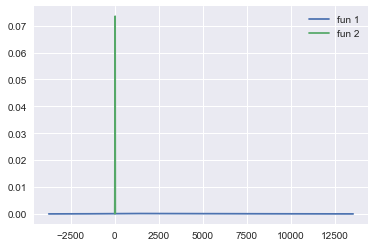

In [387]:
sns.kdeplot(np.array([function_one(i) for i in range(1,100)]),label='fun 1')
sns.kdeplot(function_two(range(1,100)) , label='fun 2')
plt.legend()

In [388]:
covariance_function(2.4,2)

1.6681421473598714e-08

In [389]:
# normal distribution to combine our model parameters
gp = lambda x,x_ : (mean_function(x),covariance_function(x,x_))

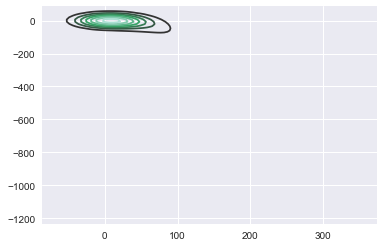

In [390]:
sns.kdeplot(np.array([gp(i,i) for i in range(1,100)]))

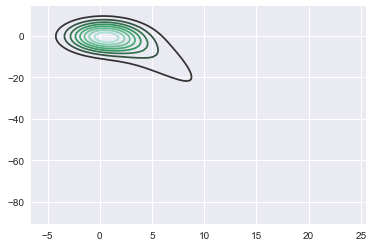

In [391]:
sns.kdeplot(np.array([gp(i,x) for i,x in zip(range(1,100),range(50,100))]))

# Gaussian  Normal Distirbution

- $ cov
f(xp), f(xq)

= k(xp, xq) = exp
−
1
2
|xp − xq|
2

. $
- $f∗ ∼ N
0, K(X∗, X∗)

, $

In [280]:
cov_normal = lambda x,x_ : np.exp(-.5*abs(x - x_)**2)

In [288]:
gaussian_vector = lambda x,x_ : sp.stats.norm(0,cov_normal(x,x_)).rvs()

(-5, 5)

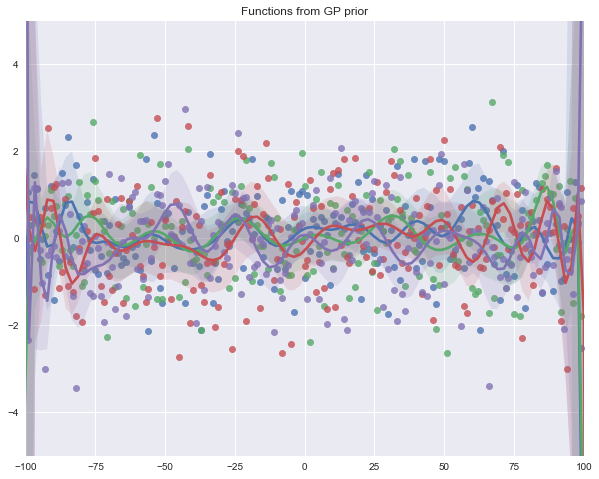

In [399]:

plt.figure(figsize=(10,8))
plt.title('Functions from GP prior')
sns.regplot(np.array(range(-100,100)),np.array([gaussian_vector(i,i) for i in range(-100,100)]),order=32)
sns.regplot(np.array(range(-100,100)),np.array([gaussian_vector(i,i) for i in range(-100,100)]),order=25)
sns.regplot(np.array(range(-100,100)),np.array([gaussian_vector(i,i) for i in range(-100,100)]),order = 27)
sns.regplot(np.array(range(-100,100)),np.array([gaussian_vector(i,i) for i in range(-100,100)]), order = 31)
plt.xlim(-100,100)
plt.ylim(-5,5)

## Noise free predictive distribution

$f∗|X∗, X,f ∼ N
K(X∗, X)K(X, X)
−1
f,
K(X∗, X∗) − K(X∗, X)K(X, X)
−1K(X, X∗)
$

Squarred Exponential =

- $exp
−
1
2
|xp − xq|
2

.$

In [640]:
squarred_exp_cv = lambda x_train,x_test : np.exp(-.5*abs(x_train - x_test)**2)

In [641]:
training = range(-100,100)
test = range(-200,100)
cov_training_training  = np.array([[cov_normal(x_,x_) for x_ in range(-100,100)] for _ in range(-100,100)])
cov_training_test = np.array([[cov_normal(x_,x) for (x_,x) in zip(range(-100,100),range(-200,100))]
                              for _ in range(-100,100)])

# Noisy predictive distribution
- training points = (-100,100)
- test points = (-200,300,400) # only two

In [517]:
training_funcion  =  lambda x: x/4

In [827]:
train_x = np.linspace(-500,100,300) # x values
test_x = np.linspace(-10,99,20)
train_y = np.array(list(map(training_funcion,train_x))).reshape(-1,1) # columns vector
train_y_var = np.var(train_y)

In [828]:
list(test_x)

[-10.0,
 -4.2631578947368425,
 1.473684210526315,
 7.2105263157894726,
 12.94736842105263,
 18.684210526315788,
 24.421052631578945,
 30.157894736842103,
 35.89473684210526,
 41.631578947368418,
 47.368421052631575,
 53.105263157894733,
 58.84210526315789,
 64.578947368421041,
 70.315789473684205,
 76.05263157894737,
 81.78947368421052,
 87.526315789473671,
 93.263157894736835,
 99.0]

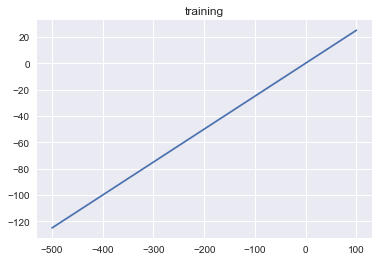

In [829]:
plt.plot(train_x,train_y)
plt.title('training');

In [830]:
train_y_var

1887.5418060200668

In [831]:

#squarred exponential covariance kernel
squarred_exponential_kernel = lambda x_,x: np.exp(-.5*(x_ - x)**2)


In [832]:
# find the covariance between the data points
cov_test_train_matrix = np.zeros((len(test_x),len(train_x)))
cov_test_test_matrix = np.zeros((len(test_x),len(test_x)))
cov_train_test_matrix = np.zeros((len(train_x),len(test_x)))
cov_train_train_matrix = np.zeros((len(train_x),len(train_x))) # assume noisy prediction
                                 

for idx_test, x_test in enumerate(test_x):
    for idx_train, x_train in enumerate(train_x):
        cov_test_train_matrix[idx_test,idx_train] = squarred_exponential_kernel(x_test,x_train)

for idx_test1, x_test1 in enumerate(test_x):
    for idx_test2, x_test2 in enumerate(test_x):
        cov_test_test_matrix[idx_test1,idx_test2]= squarred_exponential_kernel(x_test1,x_test2)
                                 
for idx_train, x_train in enumerate(train_x):
    for idx_test, x_test in enumerate(test_x):
        cov_train_test_matrix[idx_train,idx_test] = squarred_exponential_kernel(x_train,x_test)

for idx_train1, x_train1 in enumerate(train_x):
    for idx_train2, x_train2 in enumerate(train_x):
        cov_train_train_matrix[idx_train1,idx_train2] = squarred_exponential_kernel(x_train1,x_train2)
        
 

In [833]:
 # assume noisy predictions so teh covariance between the training points (train,train) has
# to add the variance of the y values
training_y_cov_matrix = np.zeros((len(cov_train_train_matrix),len(cov_train_train_matrix)), int)
np.fill_diagonal(training_y_cov_matrix, train_y_var)

In [834]:
cov_train_train_matrix = cov_train_train_matrix  + training_y_cov_matrix 

In [835]:
expected_mean_noisy_predictions = cov_test_train_matrix @ np.linalg.inv(cov_train_train_matrix) @train_y 

In [836]:
expected_mean_noisy_predictions  # test points,  predicted means

array([[-0.00167084],
       [-0.00071718],
       [ 0.00025115],
       [ 0.00120127],
       [ 0.00212311],
       [ 0.00304346],
       [ 0.00400115],
       [ 0.00500526],
       [ 0.00601691],
       [ 0.00697653],
       [ 0.00785747],
       [ 0.00869936],
       [ 0.00958654],
       [ 0.01058178],
       [ 0.01166724],
       [ 0.01274557],
       [ 0.01370913],
       [ 0.01452828],
       [ 0.015287  ],
       [ 0.01598296]])

In [837]:
test_x

array([-10.        ,  -4.26315789,   1.47368421,   7.21052632,
        12.94736842,  18.68421053,  24.42105263,  30.15789474,
        35.89473684,  41.63157895,  47.36842105,  53.10526316,
        58.84210526,  64.57894737,  70.31578947,  76.05263158,
        81.78947368,  87.52631579,  93.26315789,  99.        ])

In [838]:
expected_cov_noisy_predictions = cov_test_test_matrix - cov_test_train_matrix @ np.linalg.inv(cov_train_train_matrix)\
                    @ cov_train_test_matrix

In [839]:
expected_cov_noisy_predictions 

array([[  9.99499413e-001,  -3.60707238e-008,   7.86504468e-017,
         -5.15134731e-028,  -2.91415662e-036,   1.87762374e-046,
          1.02682962e-055,  -1.70319300e-065,  -4.11947444e-075,
          9.12557027e-085,   1.49613620e-094,  -3.91486962e-104,
         -3.27262773e-114,   1.82511162e-123,   2.50369655e-135,
         -8.98954200e-143,   2.74379175e-153,   3.69846602e-162,
         -2.20024988e-172,  -1.22776682e-181],
       [ -3.60707238e-008,   9.99454295e-001,  -3.11993651e-008,
          7.69513909e-017,  -1.38551157e-027,  -2.73281573e-036,
          2.77597656e-046,   1.05526401e-055,  -1.93786500e-065,
         -4.29064505e-075,   9.02252488e-085,   1.31238418e-094,
         -4.01961701e-104,  -2.03985061e-114,   2.02809226e-123,
         -1.50649332e-134,  -9.40413495e-143,   2.79690327e-153,
          3.46266838e-162,  -2.86829236e-172],
       [  7.86504468e-017,  -3.11993651e-008,   9.99466599e-001,
         -4.20315855e-008,   6.85806383e-017,  -2.87759630e-0

In [840]:
expected_cov_noisy_predictions.shape # NXN for the test points

(20, 20)

### Now, define a normal distribution given the parameters above

In [841]:
predictive_normal_noisy = sp.stats.multivariate_normal(expected_mean_noisy_predictions.ravel(),
                                                       expected_cov_noisy_predictions  )

In [842]:
predictive_normal_noisy.rvs()

array([ 0.11631433,  0.63064788, -0.14584552,  0.05949357, -1.9149441 ,
        0.48986877, -0.16532072,  0.46508993,  0.11344726, -0.6033401 ,
        1.0326625 , -1.96165292, -1.24253234, -0.19303591,  0.29424613,
       -0.28887835, -1.31724066,  1.15679366,  0.76111333, -1.07773477])

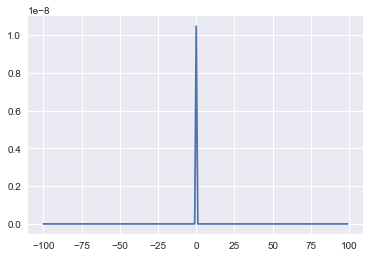

In [843]:
plt.plot(range(-100,100),[predictive_normal_noisy.pdf(i) for i in range(-100,100)])

In [844]:
predictive_normal_noisy.rvs(range_)

array([ 1.85273482, -1.29383106, -1.10035843,  0.96259757, -1.90368937,
       -1.7980305 , -2.67960172,  0.16163663,  1.48228845,  1.12602373,
        0.55455149,  0.60640082, -1.17230058,  0.11380901, -0.58935768,
       -1.15488053,  1.35193244,  0.51629356,  0.70305001, -1.59059142])

In [845]:
test_x

array([-10.        ,  -4.26315789,   1.47368421,   7.21052632,
        12.94736842,  18.68421053,  24.42105263,  30.15789474,
        35.89473684,  41.63157895,  47.36842105,  53.10526316,
        58.84210526,  64.57894737,  70.31578947,  76.05263158,
        81.78947368,  87.52631579,  93.26315789,  99.        ])

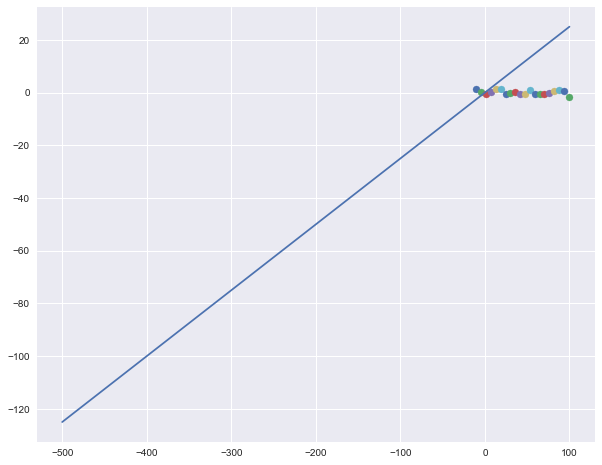

In [846]:
plt.figure(figsize=(10,8))
range_ = 1
predicted_points = predictive_normal_noisy.rvs(range_).T
#plt.scatter(test_x[0] ,predicted_points[0])

[plt.scatter(test_x[i],predicted_points[i]) for i in range(len(test_x))]
#plt.scatter(test_x[2],predicted_points[2])
#3plt.scatter(test_x[3],predicted_points[3])
plt.plot(train_x,train_y)
#plt.scatter(test_x[0],training_funcion(test_x[0]),label='X');#

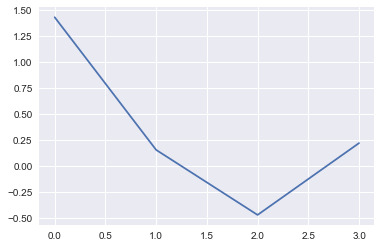

In [847]:
plt.plot([np.mean(predicted_points[0]), np.mean(predicted_points[1]), np.mean(predicted_points[2]),
         np.mean(predicted_points[3])])

In [ ]:
np.random.multivariate_normal()

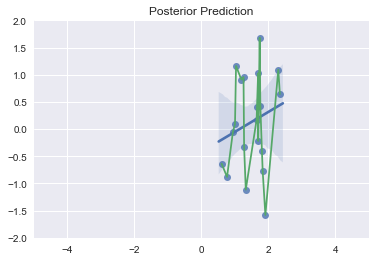

In [549]:
# random draws from the distrbution's posterior predictive
predicted_points = predictive_normal_noisy.rvs(20).T
predicted_points = np.array(sorted(predicted_points.T, key=lambda x: x[0])).T # sort the points
sns.regplot(*predicted_points,order=1)

#sns.regplot(*predicted_points,order=2)
plt.plot(*np.array(sorted(predicted_points.T, key=lambda x: x[0])).T) # plot them in order of smallest to largest
plt.xlim(-5,5)
plt.ylim(-2,2);
plt.title('Posterior Prediction')

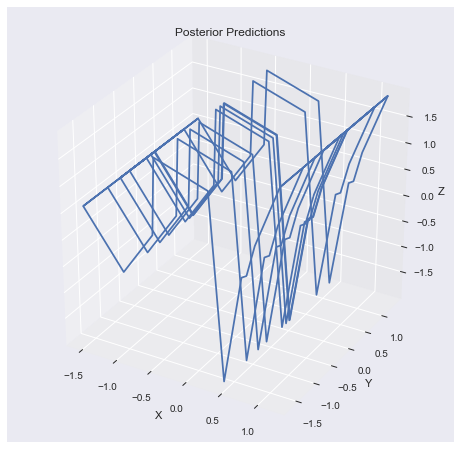

In [469]:


predicted_points = predictive_normal_noisy.rvs(10).T
predicted_points = np.array(sorted(predicted_points.T, key=lambda x: x[0])).T # sort the points

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')

#t = np.linspace(-3, 2, 31)
#s = np.linspace(-3, 2, 31)
x = predicted_points[0]
y = predicted_points[1]
z = predicted_points[2]

X, Y = np.meshgrid(x,y)
Z  = np.meshgrid(z,y)

ax.plot_wireframe(X,Y,Z[0],ccount=1, rcount=10)
#ax.plot_wireframe(X,Y,Z[1],ccount=1)
#ax.plot_surface(x,y,z, cmap=cm.jet, rstride=1, cstride=1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_title('Posterior Predictions')

plt.show()

In [1708]:


x, y = np.mgrid[-5.0:5.0:50j, -5.0:5.0:50j]

# Need an (N, 2) array of (x, y) pairs.
xy = np.column_stack([x.flat, y.flat])
print(xy)
mu = np.array([0.0, 0.0])

sigma = np.array([.5, .5])
covariance = np.diag(sigma**2)

z =predictive_normal_noisy .pdf(xy)

# Reshape back to a (30, 30) grid.
z = z.reshape(x.shape)





fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(111, projection='3d')



ax.plot_surface(x,y,z)
#ax.plot_wireframe(x,y,z)
plt.title('PDF of multivariate gaussian process')
plt.show()

[[-5.         -5.        ]
 [-5.         -4.79591837]
 [-5.         -4.59183673]
 ..., 
 [ 5.          4.59183673]
 [ 5.          4.79591837]
 [ 5.          5.        ]]


ValueError: operands could not be broadcast together with shapes (2500,2) (20,) 

# Gaussian Regression with Cholesky Factorization

In [492]:
#squarred exponential covariance kernel
squarred_exponential_kernel = lambda x_,x: np.exp(-.5*abs(x_ - x)**2)

In [491]:
L = np.linalg.cholesky()

In [853]:

arr = numpy.array([1 for _ in range(10)])
mat = numpy.diag(arr)
mat

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

# New Attempt from Readings. Bayesian Gaussian Process Regression
- Gaussian Process for Regression: A Quick Introduction
    - M. Ebden

In [388]:


def squarred_exponential_kernel_w_noise( max_covar, x1, x2, l=1, train=False, var_y = None):
    """Calculated squarred exponential kernel.
    assumes x1 and x3 and matrices.
    if train = True, then return an additional noise parameter for the observations"""
    

    if train  == False:
        return max_covar*np.exp( -(x1-x2.T)**2 / 2*l**2 ) 
    else:
        arr = numpy.array([1 for _ in range(x1.shape[1])])
        mat = numpy.diag(arr)
        return max_covar*np.exp( -(x1-x2.T)**2 / 2*l**2 )  + var_y*mat # add noise for the observations

In [389]:
def squarred_kernel(a, b, param=2.0, train=False, train_noise = .05):
    """Calculated the squarred exponential kernel. 
    Adds a noise term for the covariance of the training data
    Adjusting the param changes the difference where points will have a positive covariance
    Returns a covaraince Matrix"""
    if train == False:
        sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
        return np.exp(-.5 * (1/param) * sqdist)
    else:
        noisy_observations = train_noise*np.eye(len(a))
        sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T) 
        return np.exp(-.5 * (1/param) * sqdist) + noisy_observations 

In [390]:
train_x = np.array(np.linspace(-20,20,4)).reshape(-1,1)
train_y_func = lambda x: x+4/(x**2-10*x+125/x)
#train_y_func = lambda a,b : (a*b)/(a**2) - b
train_y_numbers = np.array([train_y_func(_) for _ in train_x]).reshape(-1,1)
y_var = np.var(train_y_numbers)
#max_covariance = np.sqrt(y_var) ## not sure a good number to choose for the noise of measuring your observations
max_covariance = 5
test_x = np.array(np.linspace(-15,15,20)).reshape(-1,1)

In [391]:
def test_gaussian_process(test_x, train_x, train_y_numbers,y_var, return_cov = False,
                          return_sample = False, max_cov = 10):
    """Test one new point in the Gaussian process or an array of points
    Returns the mean, var from normal distribution from the sampled point.
    Return cov = True will return the full covariance matrix.
    
    If return_sample= True 
    returns samples from the informed posterior and the uninformed prior distribution"""
    
    y_var = np.var(train_y_numbers)
    
    # define the covaraince functions
    covariance_train_train = squarred_kernel(train_x,train_x,train=True)
    
    covariance_test_train  = squarred_kernel(test_x,train_x)
    covariance_test_test  = squarred_kernel(test_x,test_x)

    # Use cholskey decomposition to increase speed for calculating mean
    try:
        L_test_test = np.linalg.cholesky(covariance_test_test + 1e-15*np.eye(len(test_x)))
        L_train_train = np.linalg.cholesky(covariance_train_train + .00005*np.eye(len(train_x)))
        Lk = np.linalg.solve(L_train_train, covariance_test_train.T)
        mus = np.dot(Lk.T, np.linalg.solve(L_train_train, train_y_numbers)).reshape((len(test_x),))
        # Compute the standard deviation so we can plot it
        s2 = np.diag(covariance_test_test) - np.sum(Lk**2, axis=0)
        stdv = np.sqrt(abs(s2))
        

    # Full matrix calculation of mean and covariance, much slower than cholesky decomposition
    except Exception as e:
        print(e)#LinAlgError: # In case the covaraince matrix is not positive definite 
        mus = covariance_test_train  @ np.linalg.pinv(covariance_train_train ) @ train_y_numbers
        s2 = covariance_test_test - covariance_test_train @ np.linalg.pinv(covariance_train_train ) \
                     @ covariance_test_train.T
        
    

    def sample_from_posterior(n_priors=3, n_posteriors=3):
        """Draw samples from the prior distribution of the GP.
        len(test_x) is the number of samplese to draw.
        Resource: http://katbailey.github.io/post/gaussian-processes-for-dummies/.
        
        N-Posteriors / N-Priors tells the number of functions to samples from the dsitribution"""

        
        # Draw samples from the posterior at our test points.
        L = np.linalg.cholesky(covariance_test_test + 1e-6*np.eye(len(test_x)) - np.dot(Lk.T, Lk))
        f_post = mus.reshape(-1,1) + np.dot(L, np.random.normal(size=(len(test_x),n_posteriors)))

        # Sample 3 sets of standard normals for our test points,
        # multiply them by the square root of the covariance matrix
        f_prior_uninformed = np.dot(L_test_test, np.random.normal(size=(len(test_x),n_priors)))
        return (f_prior_uninformed, f_post)


    if return_cov == True:
        return y_pred_mean.ravel(), var_y_pred_diag.ravel(), var_y_pred
        
    if return_sample == True:
        prior_post = sample_from_posterior()
        return mus.ravel(), s2.ravel(), prior_post[0], prior_post[1]
    else:
        return mus.ravel(), s2.ravel()
    
   

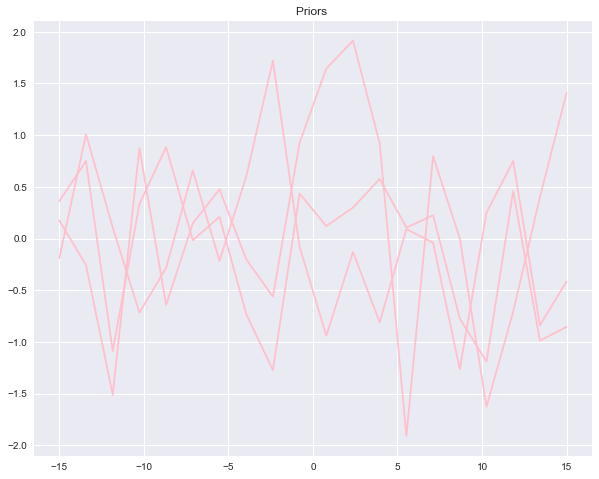

In [392]:
plt.figure(figsize=(10,8))
plt.plot(test_x,prior,color='pink')
plt.title("Priors ");


In [393]:
m,var, prior, post = test_gaussian_process(test_x, train_x, train_y_numbers, y_var, return_sample = True)

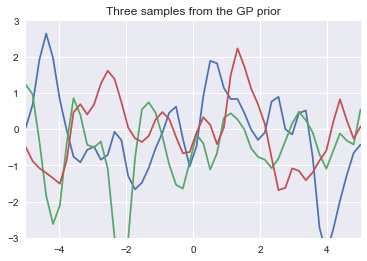

In [394]:
import numpy as np
import matplotlib.pyplot as pl

# Test data
n = 50
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

# Define the kernel function
def kernel(a, b, param):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-.5 * (1/param) * sqdist)

param = 0.1
K_ss = kernel(Xtest, Xtest, param)

# Get cholesky decomposition (square root) of the
# covariance matrix
L = np.linalg.cholesky(K_ss + 1e-15*np.eye(n))
# Sample 3 sets of standard normals for our test points,
# multiply them by the square root of the covariance matrix
f_prior = np.dot(L, np.random.normal(size=(n,3)))

# Now let's plot the 3 sampled functions.
pl.plot(Xtest, f_prior)
pl.axis([-5, 5, -3, 3])
pl.title('Three samples from the GP prior')
pl.show()

In [395]:
Xtrain

array([[-4],
       [-3],
       [-2],
       [-1],
       [ 1]])

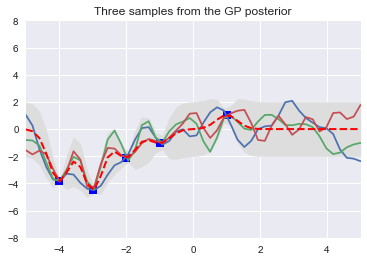

In [396]:
# Noiseless training data
Xtrain = np.array([-4, -3, -2, -1, 1]).reshape(5,1)
#ytrain = np.sin(Xtrain)
y_train_func =  lambda x: x+4/(x**2-10*x+125/x)
ytrain = np.array([y_train_func(i) for i  in Xtrain]).reshape(-1,1)

# Apply the kernel function to our training points
K = kernel(Xtrain, Xtrain, param)
L = np.linalg.cholesky(K + 0.00005*np.eye(len(Xtrain)))

# Compute the mean at our test points.
K_s = kernel(Xtrain, Xtest, param)
Lk = np.linalg.solve(L, K_s)
mu = np.dot(Lk.T, np.linalg.solve(L, ytrain)).reshape((n,))

# Compute the standard deviation so we can plot it
s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
stdv = np.sqrt(s2)
# Draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ss + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,3)))

pl.plot(Xtrain, ytrain, 'bs', ms=8)
pl.plot(Xtest, f_post)
pl.gca().fill_between(Xtest.flat, mu-2*stdv, mu+2*stdv, color="#dddddd")
pl.plot(Xtest, mu, 'r--', lw=2)
pl.axis([-5, 5, -8, 8])
pl.title('Three samples from the GP posterior')
pl.show()

In [397]:

def sample_and_plot_posterior(train_x, train_y_func, test_gaussian_process, range_to_sample=np.linspace(-10,10,15)):
    """Plot potential posterior functions after sampling from the true function.
    Notice how the varaince decreases around the sampled points"""
    train_x = np.array(np.linspace(-20,20,1)).reshape(-1,1)
    train_y_numbers = np.array([train_y_func(_) for _ in train_x]).reshape(-1,1)
    for i in range_to_sample:
        print(f"Point Sampled x = {train_x.ravel()[-1]}")
        m,var, prior, post = test_gaussian_process(test_x, train_x, train_y_numbers, y_var, return_sample = True)
        plt.figure(figsize=(14,10))

        plt.gca().fill_between(test_x.flat, m-2*np.sqrt(var), m+2*np.sqrt(var), color="#dddddd",label='95% confidence')
        plt.scatter(train_x.ravel(), train_y_numbers,marker='*',label='Samples', linewidth=5, color='red')

        plt.plot(np.linspace(-20,20,200),[train_y_func(i) for i in np.linspace(-20,20,200)], label='real function',
                linestyle="--")
        plt.plot(test_x,post,color='black',label='Draws from the posterior');
        #plt.scatter(train_x,train_y_numbers)
        #plt.scatter(test_x,m,label='MU',color='red', linewidth=10, marker='*');
        plt.legend()
        plt.title('Posteriors, and Actual Function')
        plt.show();

        # Update training data with the sampled point
        train_x = train_x.ravel()
        train_x = np.append(train_x,i)
        train_x = train_x.reshape(-1,1)
        train_y_numbers = np.array([train_y_func(_) for _ in train_x]).reshape(-1,1)

        # sleep for three seconds
        time.sleep(3)

Point Sampled x = -20.0


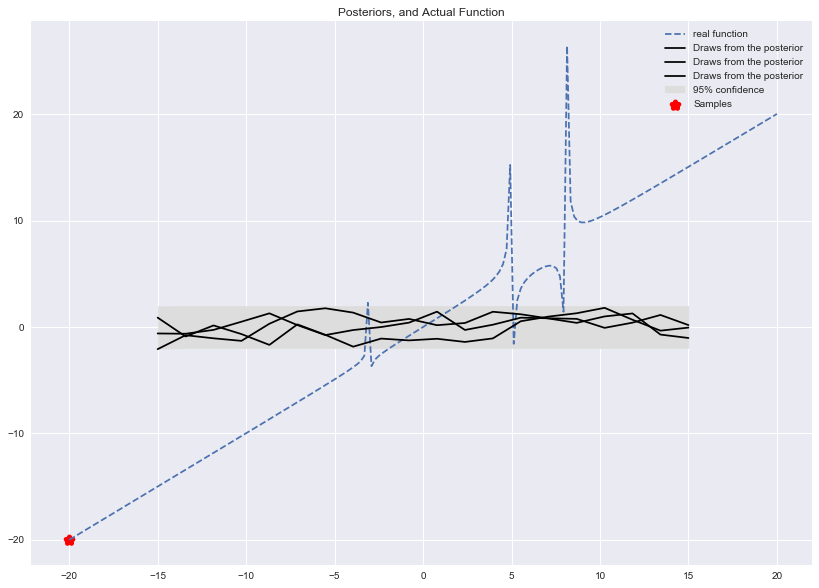

Point Sampled x = -10.0


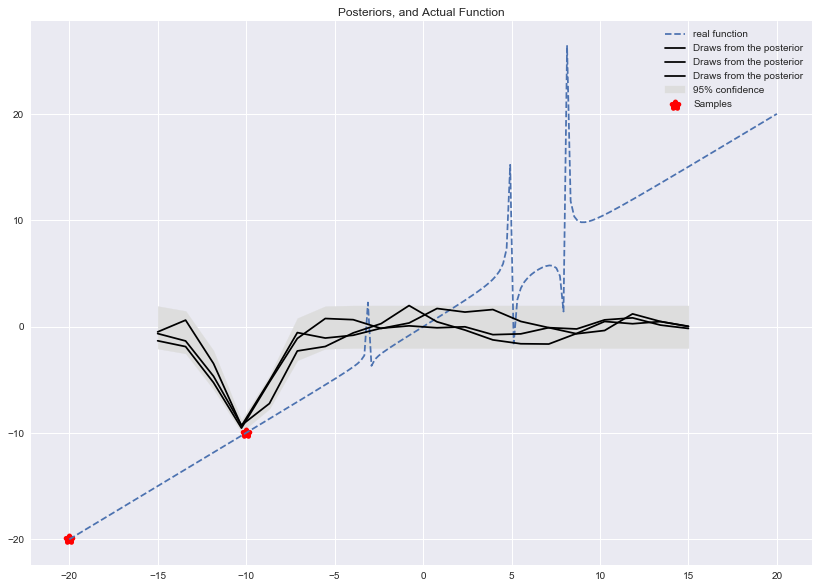

Point Sampled x = -8.571428571428571


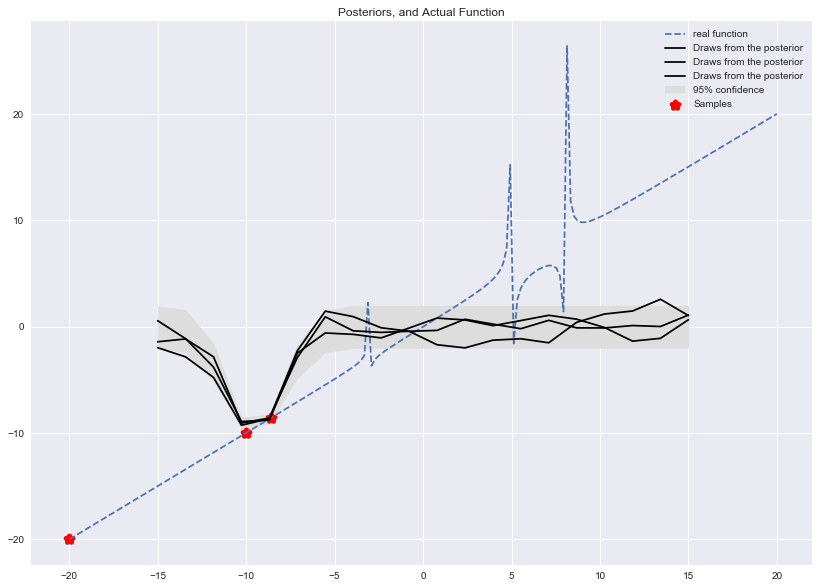

Point Sampled x = -7.142857142857142


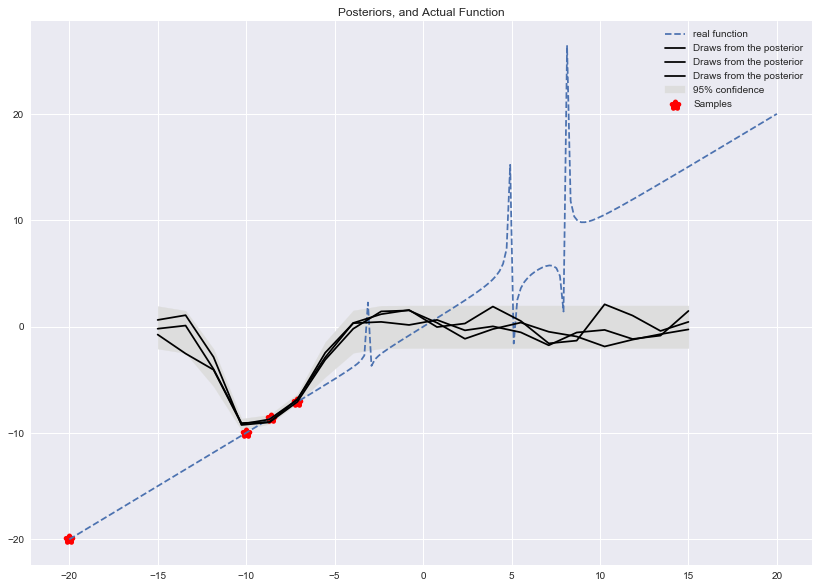

Point Sampled x = -5.714285714285714


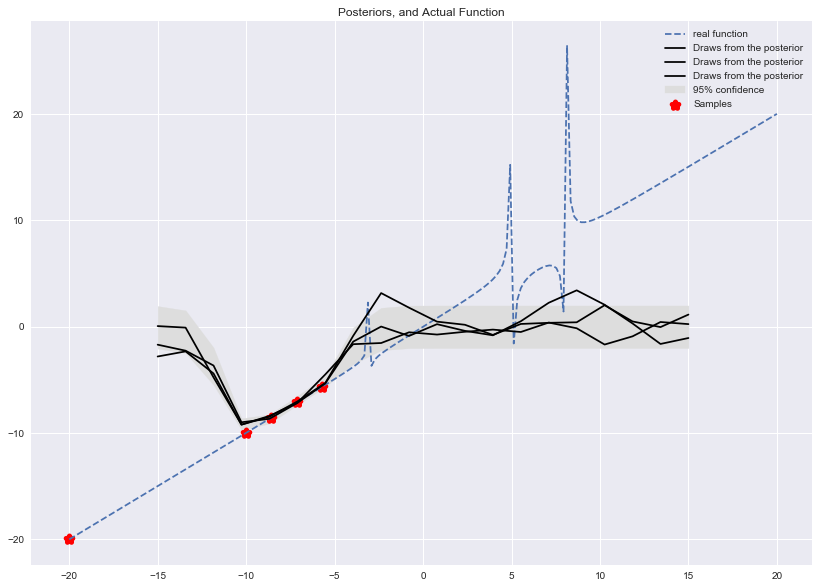

Point Sampled x = -4.285714285714286


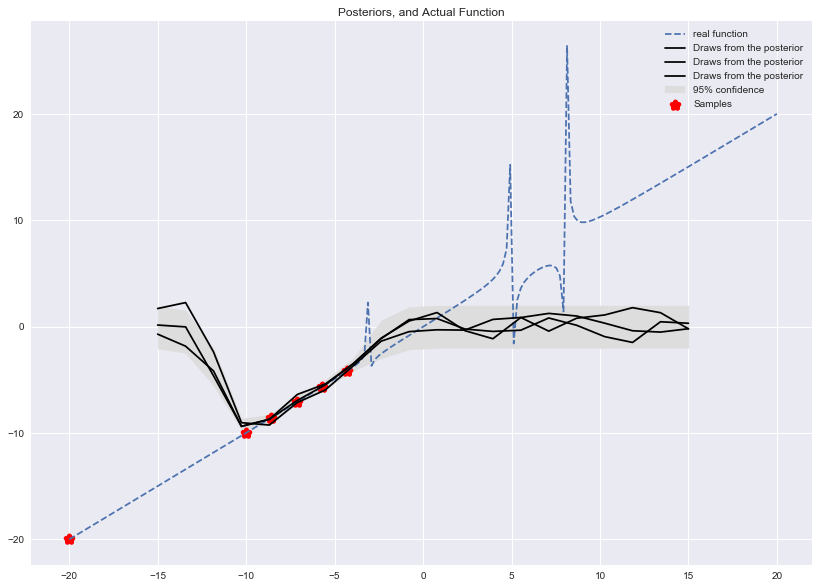

Point Sampled x = -2.8571428571428568


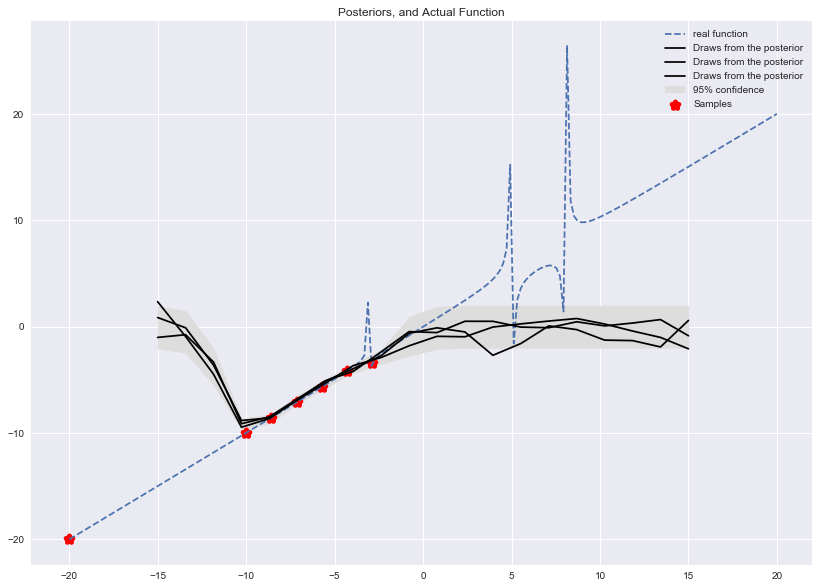

Point Sampled x = -1.4285714285714288


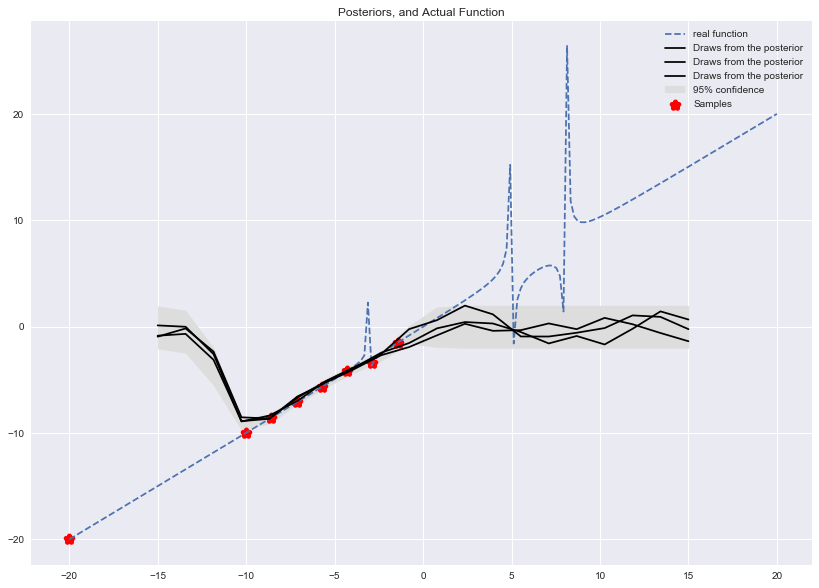

/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


KeyboardInterrupt: 

In [398]:
sample_and_plot_posterior(train_x, train_y_func, test_gaussian_process)

### Best estimate for Y* is given by the mean of the distribution


### Implement Expected Improvement


In [470]:
def expected_improvement(mean_x, sigma_squarred_x, y_val_for_best_hyperparameters, normal_dist):
    """Finds the expected improvement of a point give the current best point.
    """
    from scipy.stats import norm
    
    with np.errstate(divide='ignore'): # in case sigma equals zero
        sigma_x = np.sqrt(sigma_squarred_x) # get the standard deviation from the variance

        Z = (mean_x - y_val_for_best_hyperparameters) / sigma_x
        
        if round(sigma_x,8) == 0:
            return 0
        else:

            return (mean_x - y_val_for_best_hyperparameters)*normal_dist.cdf(Z) + sigma_x*normal_dist.pdf(Z)

In [471]:
def sample_from_function( y_function, 
                        train_x, train_y_numbers, testing_domain = range(-200,200,10), n = 20,
                        adaption_n = .95):
    """Sample N times from the unknown function and for each time find the 
    point that will have the highest expected improvement (find the maxima of the function).
    
    Returns a generator of x_sampled_points, y_sampled_points, sampled_variance, best_x, best_y
    
    Starts off the search for expected improvement with a coarse search and then hones in on 
    the domain the the highest e xpected improvement.
    
    Adaption_n decreases the possible range of values to find a better number centered around the best x value"""
    start_point = np.random.randn()
    best_x = start_point
    best_y = y_function(start_point) # initial best y value based on start point
    start_y = y_function(start_point) 
    # for plotting the points sampled
    x_sampled_points = []
    y_sampled_points = []
    sampled_variance =[] 
    

    for i in range(n):
        if i == 0:
            
            s_p = np.array([testing_domain]).reshape(-1,1)
            
            
            # find the next x-point to sample
            mus, vars_ = test_gaussian_process(np.array(s_p), train_x, train_y_numbers, np.var(s_p) )
            sigmas = np.sqrt(abs(vars_))
            list_of_expected_improvements = []
    
            
            for m,v,point in zip(mus,vars_,s_p): # create a new normal for each point

                
                point_normal_distribution = stats.norm(m,v)
                current_expected_improvement = expected_improvement( m,
                                                    v, best_y  ,point_normal_distribution)
                #print(current_expected_improvement, ' EXPECTED IMPROVEMENT')
                list_of_expected_improvements.append(current_expected_improvement)
            # keep track of the best variables
            max_improv_x_idx = np.argmax(list_of_expected_improvements)
            max_improv_x = testing_domain[max_improv_x_idx]
  
            max_improv_y = y_function(max_improv_x  ) 
            if max_improv_y > best_y: ## use to find out where to search next
                best_y = max_improv_y 
                best_x = max_improv_x
            else:
                best_x = start_point
            

            sampled_variance.append(vars_[max_improv_x_idx])

            # append the point to sample
            x_sampled_points.append(max_improv_x)
            y_sampled_points.append(max_improv_y)
            
            # append our new the newly sampled point to the training data
            train_x = np.vstack((train_x, max_improv_x))
            train_y_numbers = np.vstack((train_y_numbers, max_improv_y))
            yield x_sampled_points, y_sampled_points, sampled_variance, best_x, best_y
            

        else:
            # adaptive sampling
            testing_domain_l = abs(int(testing_domain[0]*adaption_n))
            print(testing_domain_l,'domain L')
            #print(best_x - testing_domain_l, ' x - lower')
            
            testing_domain_h = abs(int(testing_domain[-1]*adaption_n))
            print(testing_domain_h,' domain H')
            # shorted the testing domain to be around the best point
            testing_domain = range(int(testing_domain_l), int(testing_domain_h))
  
            testing_domain = np.linspace(best_x - testing_domain_l, best_x + testing_domain_h, num=200).reshape(-1,1)
            
            #print(testing_domain,best_x - (10_000/i),int(n/i))
            # generate a new  normal distribution based upon the sampled x
            
            #domain = np.array([np.linspace(testing_domain[0],testing_domain[-1],250)]).reshape(-1,1)
            
            # find the next x-point to sample
            mus, vars_ = test_gaussian_process(np.array(testing_domain), train_x, train_y_numbers, np.var(s_p) )
            sigmas = np.sqrt(abs(vars_))
            list_of_expected_improvements = []
            
            for m,v,point in zip(mus,vars_,testing_domain): # create a new normal for each point
                print(m,'m','v',v,'point',point)
                
                point_normal_distribution = stats.norm(m,v)
                current_expected_improvement = expected_improvement( m,
                                                    v, best_y  ,point_normal_distribution)
                #print(current_expected_improvement, ' EXPECTED IMPROVEMENT')
                list_of_expected_improvements.append(current_expected_improvement)
             # keep track of the best variables
            max_improv_x_idx = np.argmax(list_of_expected_improvements)
            max_improv_x = testing_domain[max_improv_x_idx]
            
  
            max_improv_y = y_function(max_improv_x )
    
            if max_improv_y > best_y: ## use to find out where to search next
                best_y = max_improv_y 
                best_x = max_improv_x
            else:
                pass

            sampled_variance.append(vars_[max_improv_x_idx])

            # append the point to sample
            x_sampled_points.append(max_improv_x)
            y_sampled_points.append(max_improv_y)
            
            # append our new the newly sampled point to the training data
            train_x = np.vstack((train_x, max_improv_x))
            train_y_numbers = np.vstack((train_y_numbers, max_improv_y))
            
            yield x_sampled_points, y_sampled_points, sampled_variance, best_x, best_y
         


    

In [472]:
samples = 60

In [473]:
#x, y, variance_of_estimate, best_x,best_y = 
gen = sample_from_function(train_y_func,train_x, train_y_numbers,n=samples )

Point on x-axis just sampled =20


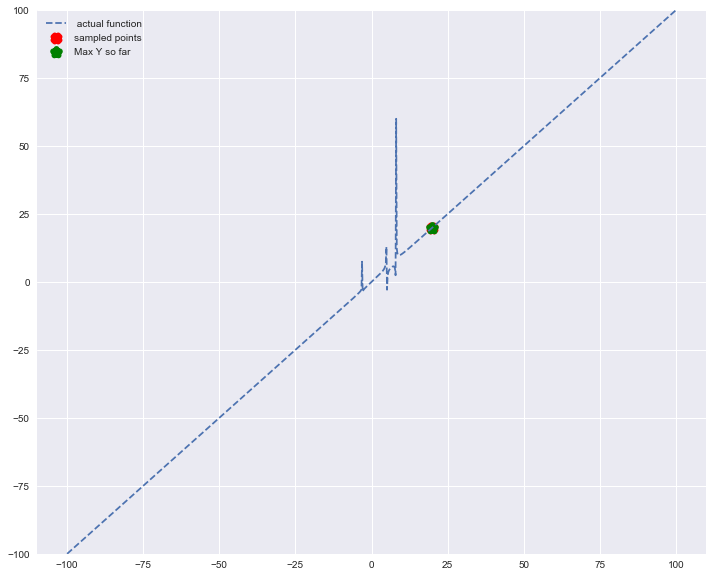

190 domain L
180  domain H
0.0 m v 1.0 point [-170.]
0.0 m v 1.0 point [-168.14070352]
0.0 m v 1.0 point [-166.28140704]
0.0 m v 1.0 point [-164.42211055]
0.0 m v 1.0 point [-162.56281407]
0.0 m v 1.0 point [-160.70351759]
0.0 m v 1.0 point [-158.84422111]
0.0 m v 1.0 point [-156.98492462]
0.0 m v 1.0 point [-155.12562814]
0.0 m v 1.0 point [-153.26633166]
0.0 m v 1.0 point [-151.40703518]
0.0 m v 1.0 point [-149.54773869]
0.0 m v 1.0 point [-147.68844221]
0.0 m v 1.0 point [-145.82914573]
0.0 m v 1.0 point [-143.96984925]
0.0 m v 1.0 point [-142.11055276]
0.0 m v 1.0 point [-140.25125628]
0.0 m v 1.0 point [-138.3919598]
0.0 m v 1.0 point [-136.53266332]
0.0 m v 1.0 point [-134.67336683]
0.0 m v 1.0 point [-132.81407035]
0.0 m v 1.0 point [-130.95477387]
0.0 m v 1.0 point [-129.09547739]
0.0 m v 1.0 point [-127.2361809]
0.0 m v 1.0 point [-125.37688442]
0.0 m v 1.0 point [-123.51758794]
0.0 m v 1.0 point [-121.65829146]
0.0 m v 1.0 point [-119.79899497]
0.0 m v 1.0 point [-117.9396984

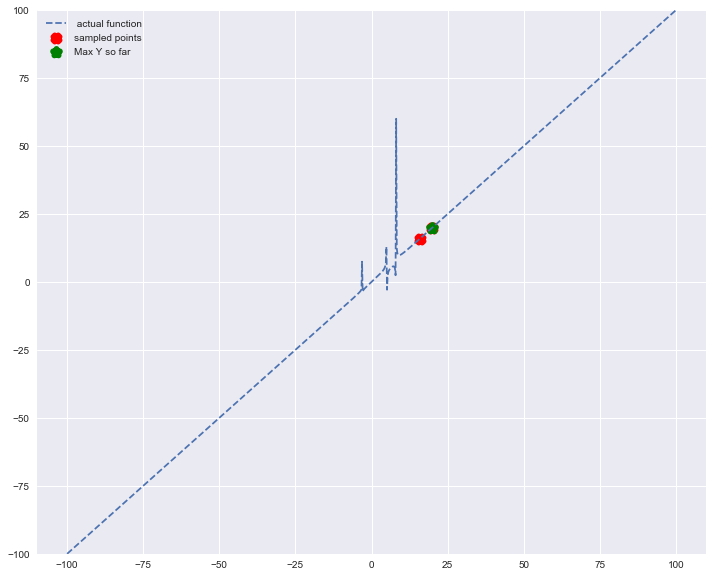

161 domain L
190  domain H
0.0 m v 1.0 point [-141.]
0.0 m v 1.0 point [-139.2361809]
0.0 m v 1.0 point [-137.47236181]
0.0 m v 1.0 point [-135.70854271]
0.0 m v 1.0 point [-133.94472362]
0.0 m v 1.0 point [-132.18090452]
0.0 m v 1.0 point [-130.41708543]
0.0 m v 1.0 point [-128.65326633]
0.0 m v 1.0 point [-126.88944724]
0.0 m v 1.0 point [-125.12562814]
0.0 m v 1.0 point [-123.36180905]
0.0 m v 1.0 point [-121.59798995]
0.0 m v 1.0 point [-119.83417085]
0.0 m v 1.0 point [-118.07035176]
0.0 m v 1.0 point [-116.30653266]
0.0 m v 1.0 point [-114.54271357]
0.0 m v 1.0 point [-112.77889447]
0.0 m v 1.0 point [-111.01507538]
0.0 m v 1.0 point [-109.25125628]
0.0 m v 1.0 point [-107.48743719]
0.0 m v 1.0 point [-105.72361809]
0.0 m v 1.0 point [-103.95979899]
0.0 m v 1.0 point [-102.1959799]
0.0 m v 1.0 point [-100.4321608]
0.0 m v 1.0 point [-98.66834171]
0.0 m v 1.0 point [-96.90452261]
0.0 m v 1.0 point [-95.14070352]
0.0 m v 1.0 point [-93.37688442]
0.0 m v 1.0 point [-91.61306533]
0.0

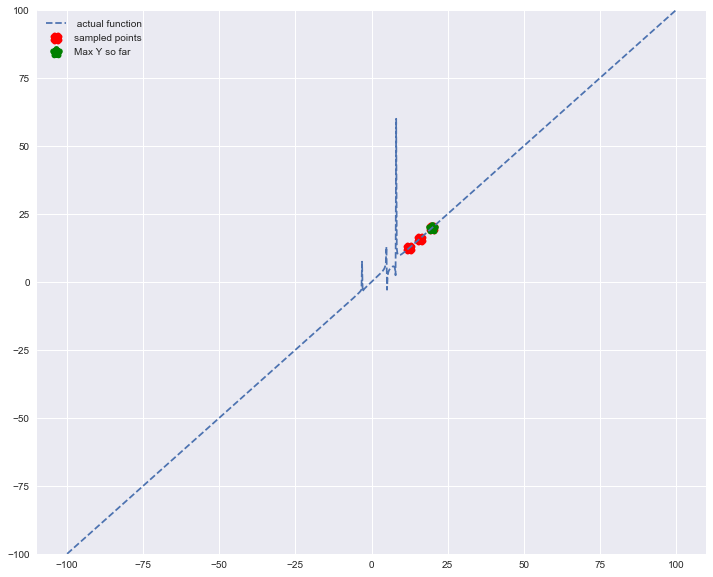

133 domain L
199  domain H
0.0 m v 1.0 point [-113.]
0.0 m v 1.0 point [-111.33165829]
0.0 m v 1.0 point [-109.66331658]
0.0 m v 1.0 point [-107.99497487]
0.0 m v 1.0 point [-106.32663317]
0.0 m v 1.0 point [-104.65829146]
0.0 m v 1.0 point [-102.98994975]
0.0 m v 1.0 point [-101.32160804]
0.0 m v 1.0 point [-99.65326633]
0.0 m v 1.0 point [-97.98492462]
0.0 m v 1.0 point [-96.31658291]
0.0 m v 1.0 point [-94.64824121]
0.0 m v 1.0 point [-92.9798995]
0.0 m v 1.0 point [-91.31155779]
0.0 m v 1.0 point [-89.64321608]
0.0 m v 1.0 point [-87.97487437]
0.0 m v 1.0 point [-86.30653266]
0.0 m v 1.0 point [-84.63819095]
0.0 m v 1.0 point [-82.96984925]
0.0 m v 1.0 point [-81.30150754]
0.0 m v 1.0 point [-79.63316583]
0.0 m v 1.0 point [-77.96482412]
0.0 m v 1.0 point [-76.29648241]
0.0 m v 1.0 point [-74.6281407]
-5.73936436145e-304 m v 1.0 point [-72.95979899]
-4.39255672235e-285 m v 1.0 point [-71.29145729]
-8.35932354278e-267 m v 1.0 point [-69.62311558]
-3.9557156503e-249 m v 1.0 point [-6

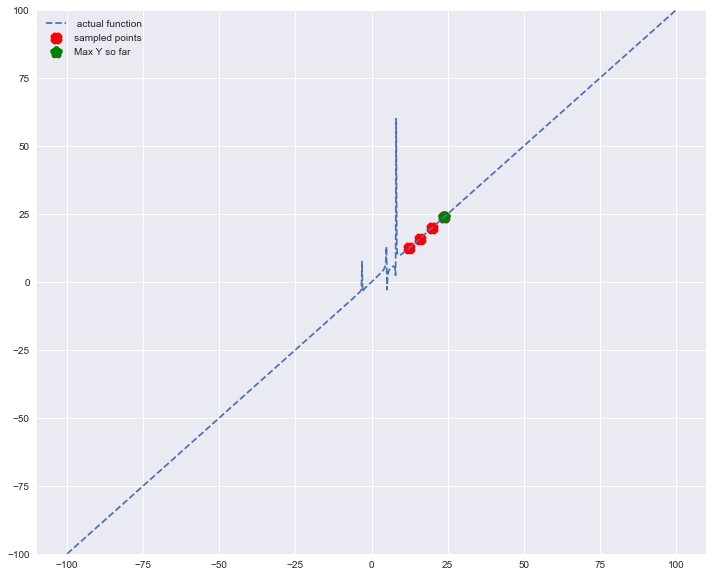

107 domain L
208  domain H
0.0 m v 1.0 point [-83.1959799]
0.0 m v 1.0 point [-81.61306533]
0.0 m v 1.0 point [-80.03015075]
0.0 m v 1.0 point [-78.44723618]
0.0 m v 1.0 point [-76.86432161]
0.0 m v 1.0 point [-75.28140704]
-1.60172860711e-312 m v 1.0 point [-73.69849246]
-2.45520496144e-294 m v 1.0 point [-72.11557789]
-1.07522268848e-276 m v 1.0 point [-70.53266332]
-1.34530554705e-259 m v 1.0 point [-68.94974874]
-4.80900570144e-243 m v 1.0 point [-67.36683417]
-4.91135692682e-227 m v 1.0 point [-65.7839196]
-1.4330440765e-211 m v 1.0 point [-64.20100503]
-1.19461907655e-196 m v 1.0 point [-62.61809045]
-2.84518944546e-182 m v 1.0 point [-61.03517588]
-1.93599743874e-168 m v 1.0 point [-59.45226131]
-3.76365853139e-155 m v 1.0 point [-57.86934673]
-2.09039084907e-142 m v 1.0 point [-56.28643216]
-3.31708517426e-130 m v 1.0 point [-54.70351759]
-1.5038260271e-118 m v 1.0 point [-53.12060302]
-1.94782715826e-107 m v 1.0 point [-51.53768844]
-7.20800505867e-97 m v 1.0 point [-49.954773

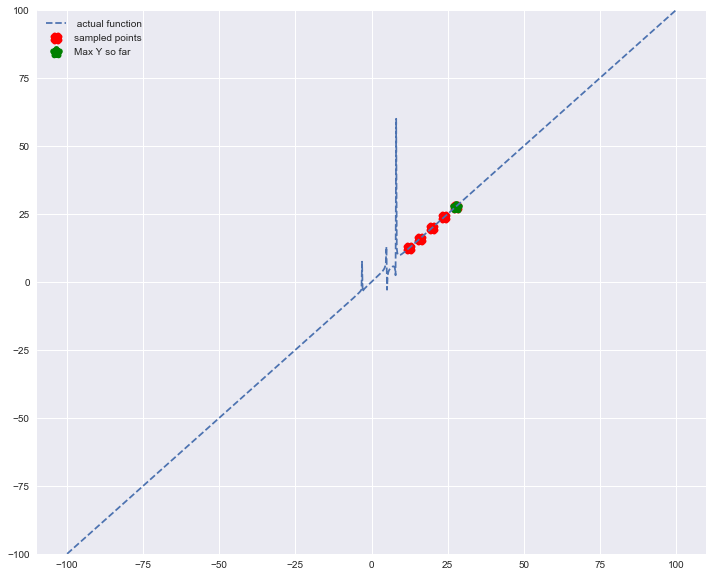

79 domain L
220  domain H
-1.92859632306e-106 m v 1.0 point [-51.3919598]
-1.91546899555e-96 m v 1.0 point [-49.88944724]
-6.15303616649e-87 m v 1.0 point [-48.38693467]
-6.39270049354e-78 m v 1.0 point [-46.88442211]
-2.14812622055e-69 m v 1.0 point [-45.38190955]
-2.33461775263e-61 m v 1.0 point [-43.87939698]
-8.20639316016e-54 m v 1.0 point [-42.37688442]
-9.3297370697e-47 m v 1.0 point [-40.87437186]
-3.43057594716e-40 m v 1.0 point [-39.3718593]
-4.07985962588e-34 m v 1.0 point [-37.86934673]
-1.56929269074e-28 m v 1.0 point [-36.36683417]
-1.95228506489e-23 m v 1.0 point [-34.86432161]
-7.85530515327e-19 m v 1.0 point [-33.36180905]
-1.02226487368e-14 m v 1.0 point [-31.85929648]
-4.30273267319e-11 m v 1.0 point [-30.35678392]
-5.85741290128e-08 m v 1.0 point [-28.85427136]
-2.57897934104e-05 m v 0.999999999998 point [-27.35175879]
-0.00367257298933 m v 0.999999964569 point [-25.84924623]
-0.169150605643 m v 0.999924839488 point [-24.34673367]
-2.51974868491 m v 0.983321496939 p

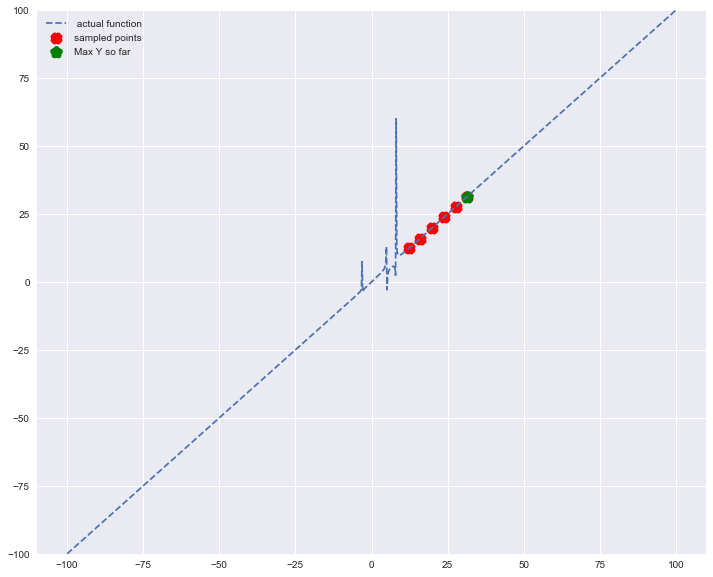

48 domain L
235  domain H
-1.36622766605 m v 0.995096696613 point [-16.75376884]
-0.0819377520167 m v 0.999982363588 point [-15.33165829]
-0.00180037638472 m v 0.999999991601 point [-13.90954774]
-0.00133623054229 m v 0.999999958164 point [-12.48743719]
-0.050022279316 m v 0.999940106498 point [-11.06532663]
-0.688529693975 m v 0.988652535911 point [-9.64321608]
-3.44765650623 m v 0.715487437032 point [-8.22110553]
-6.28010735143 m v 0.0559660718634 point [-6.79899497]
-4.16151924283 m v 0.585468744221 point [-5.37688442]
-1.00317917665 m v 0.975911459612 point [-3.95477387]
-0.087972484151 m v 0.999814754694 point [-2.53266332]
-0.00280502562206 m v 0.999999811476 point [-1.11055276]
0.000183750213045 m v 0.999999998357 point [ 0.31155779]
0.0119678516723 m v 0.999995049757 point [ 1.73366834]
0.240873142675 m v 0.997994785432 point [ 3.15577889]
1.76359082678 m v 0.892507356849 point [ 4.57788945]
4.69763773381 m v 0.237429235683 point [ 6.]
4.57155032006 m v 0.284076606081 point [ 7

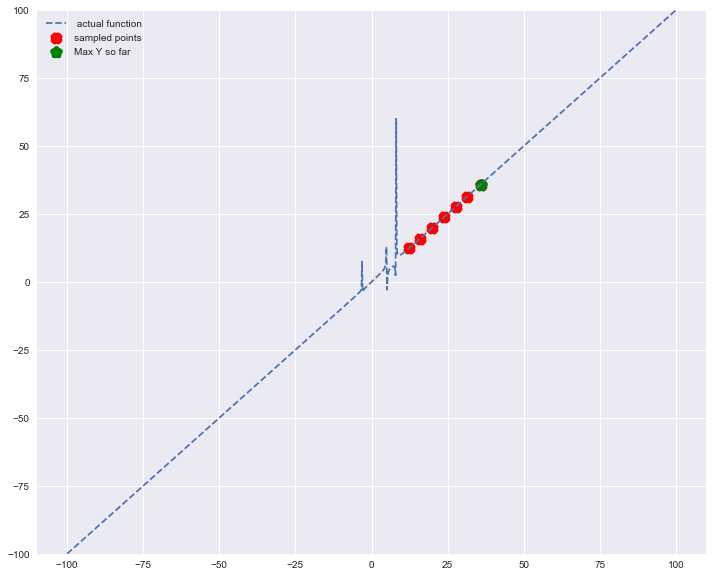

15 domain L
252  domain H
18.0687739587 m v 0.320050411888 point [ 20.86432161]
16.9609157235 m v 0.656160823935 point [ 22.20603015]
22.4249460144 m v 0.0780442938985 point [ 23.54773869]
20.0151938013 m v 0.453026335688 point [ 24.88944724]
20.4067118215 m v 0.587136293973 point [ 26.23115578]
26.3443560416 m v 0.0482437598478 point [ 27.57286432]
23.5665317488 m v 0.541887737978 point [ 28.91457286]
26.7985804486 m v 0.396238221917 point [ 30.25628141]
28.6908203945 m v 0.104545357281 point [ 31.59798995]
18.0643372515 m v 0.76001256362 point [ 32.93969849]
21.0609590001 m v 0.718854423129 point [ 34.28140704]
33.7743556037 m v 0.0749553124815 point [ 35.62311558]
25.1457110276 m v 0.480232043513 point [ 36.96482412]
7.66035120648 m v 0.951733335087 point [ 38.30653266]
0.948978430173 m v 0.999259244773 point [ 39.64824121]
0.0477931041814 m v 0.999998121146 point [ 40.98994975]
0.000978520396081 m v 0.999999999212 point [ 42.33165829]
8.14460494247e-06 m v 1.0 point [ 43.67336683]


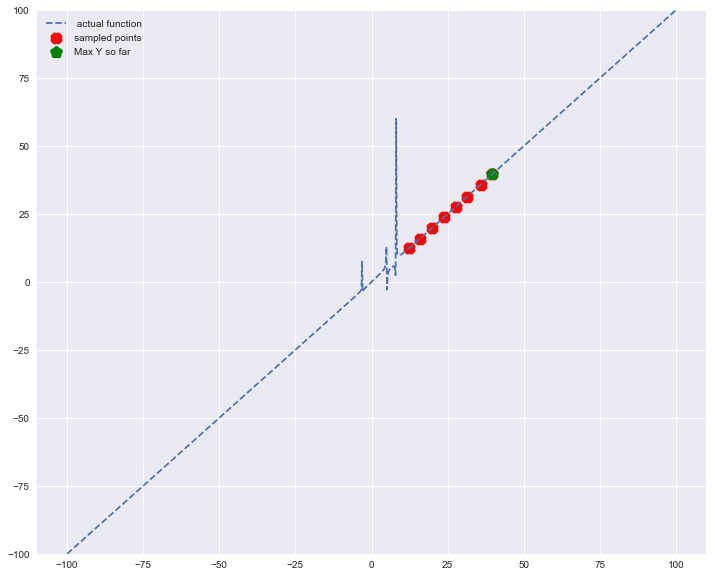

19 domain L
273  domain H
18.7173370517 m v 0.205834154713 point [ 20.64824121]
16.7115809906 m v 0.67458309982 point [ 22.11557789]
22.4948078726 m v 0.0703789346921 point [ 23.58291457]
19.4843477664 m v 0.531637668794 point [ 25.05025126]
21.9140962146 m v 0.45541857322 point [ 26.51758794]
26.1701707548 m v 0.111552131801 point [ 27.98492462]
23.441779881 m v 0.647745524028 point [ 29.45226131]
29.6610079664 m v 0.0962382450953 point [ 30.91959799]
22.4555907931 m v 0.500724380003 point [ 32.38693467]
17.2947104134 m v 0.842391963499 point [ 33.85427136]
31.4954645955 m v 0.177724673012 point [ 35.32160804]
31.4781392909 m v 0.367782697364 point [ 36.78894472]
30.6288861013 m v 0.59121081031 point [ 38.25628141]
37.6296105879 m v 0.0503606170999 point [ 39.72361809]
20.3714280887 m v 0.71009221799 point [ 41.19095477]
3.82959693853 m v 0.989728049149 point [ 42.65829146]
0.245620638801 m v 0.999957738298 point [ 44.12562814]
0.00536876035795 m v 0.999999979808 point [ 45.59296482]


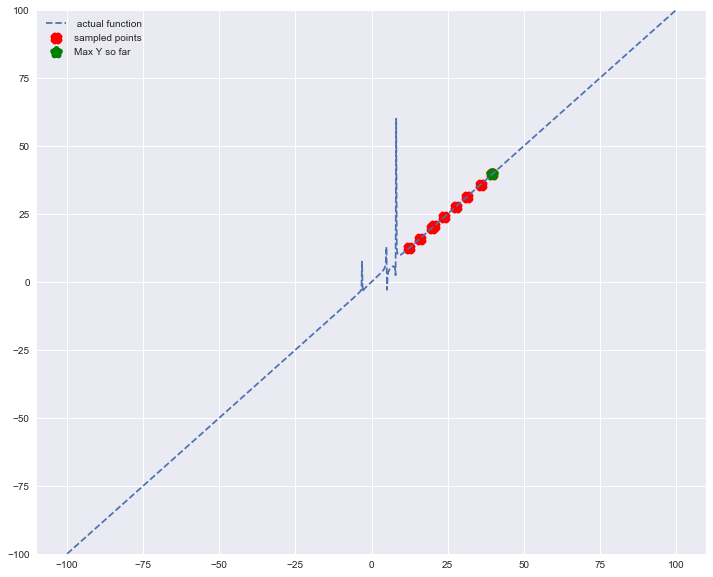

19 domain L
297  domain H
20.2848056484 m v 0.04026040399 point [ 20.64824121]
18.9625531156 m v 0.403304560677 point [ 22.2361809]
22.7497913091 m v 0.0478465572015 point [ 23.8241206]
18.5298457965 m v 0.657632248912 point [ 25.4120603]
24.5348557538 m v 0.205121001524 point [ 27.]
24.4576134384 m v 0.390857630323 point [ 28.5879397]
26.3620987611 m v 0.436582766052 point [ 30.1758794]
27.7101520731 m v 0.166593747007 point [ 31.7638191]
16.3175016962 m v 0.856119217948 point [ 33.35175879]
27.781505464 m v 0.377812096279 point [ 34.93969849]
32.864004237 m v 0.231834296292 point [ 36.52763819]
29.8101461236 m v 0.637871822289 point [ 38.11557789]
37.685277601 m v 0.0491162333172 point [ 39.70351759]
18.7998986113 m v 0.752977593026 point [ 41.29145729]
2.71214421218 m v 0.994847736749 point [ 42.87939698]
0.111009287554 m v 0.999991367469 point [ 44.46733668]
0.0012878918186 m v 0.999999998838 point [ 46.05527638]
4.23498975074e-06 m v 1.0 point [ 47.64321608]
3.94709183443e-09 m v 

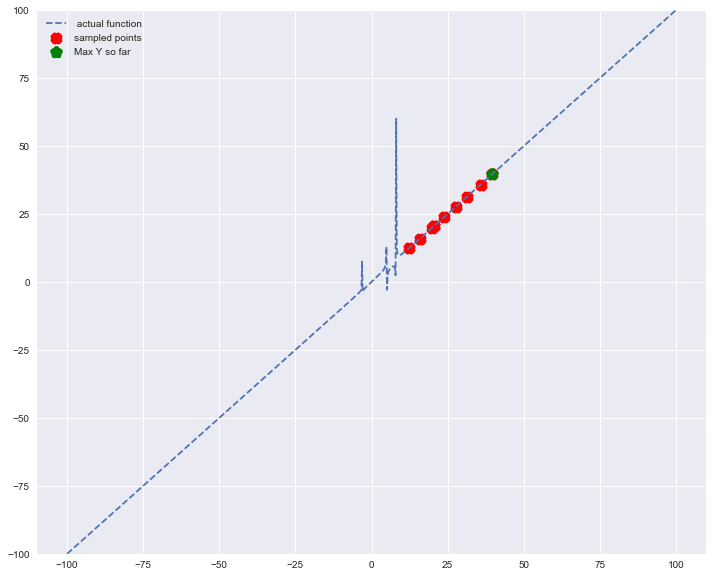

19 domain L
319  domain H
20.4547183455 m v 0.0223123043489 point [ 20.64824121]
19.3935627987 m v 0.383238120022 point [ 22.34673367]
22.4843473829 m v 0.0737206430846 point [ 24.04522613]
18.6488151477 m v 0.693083573141 point [ 25.74371859]
26.133061567 m v 0.0604919376398 point [ 27.44221106]
23.270550635 m v 0.613507933854 point [ 29.14070352]
29.4626868299 m v 0.121832322903 point [ 30.83919598]
21.0813987424 m v 0.582545338374 point [ 32.53768844]
20.1349192279 m v 0.73637433891 point [ 34.2361809]
34.2977579992 m v 0.049991279473 point [ 35.93467337]
28.4817131324 m v 0.683874632454 point [ 37.63316583]
37.607362725 m v 0.093681074283 point [ 39.33165829]
22.9240180189 m v 0.633249453957 point [ 41.03015075]
3.44054737338 m v 0.991708917274 point [ 42.72864322]
0.122250998566 m v 0.999989530544 point [ 44.42713568]
0.00102674764087 m v 0.999999999262 point [ 46.12562814]
2.03813614912e-06 m v 1.0 point [ 47.8241206]
9.56224163099e-10 m v 1.0 point [ 49.52261307]
1.06033533401e-

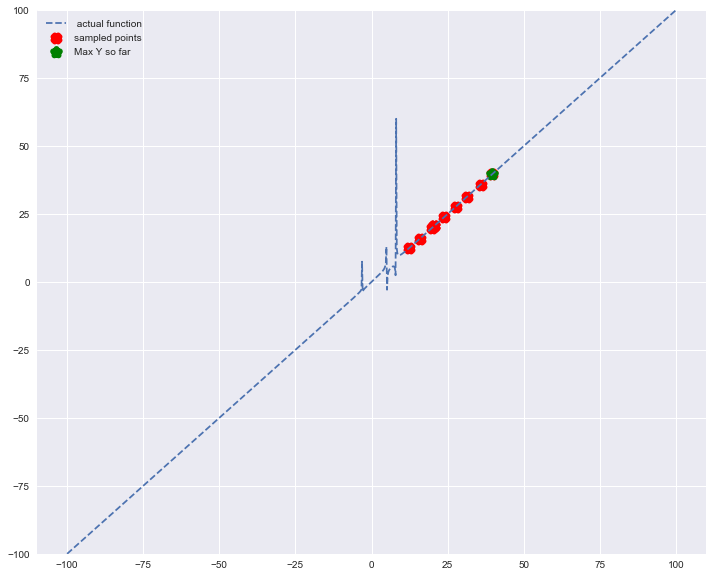

19 domain L
340  domain H
20.5198487573 m v 0.0154324940687 point [ 20.64824121]
19.7198845131 m v 0.373595053415 point [ 22.45226131]
21.9731947002 m v 0.136122665793 point [ 24.25628141]
19.5476929347 m v 0.643788626375 point [ 26.06030151]
26.3465098926 m v 0.0778470218533 point [ 27.86432161]
24.0016817008 m v 0.623497776246 point [ 29.66834171]
29.2415055059 m v 0.0715887848944 point [ 31.47236181]
16.4629733008 m v 0.845679452807 point [ 33.27638191]
29.2694261582 m v 0.298876117158 point [ 35.08040201]
30.9507649938 m v 0.418449066803 point [ 36.88442211]
33.7963776049 m v 0.386552905426 point [ 38.68844221]
31.020400048 m v 0.332859638201 point [ 40.49246231]
6.38944493439 m v 0.971410983491 point [ 42.29648241]
0.259791460862 m v 0.999952721163 point [ 44.10050251]
0.0020756354594 m v 0.999999996982 point [ 45.90452261]
3.25818932518e-06 m v 1.0 point [ 47.70854271]
1.00484348591e-09 m v 1.0 point [ 49.51256281]
6.0885983463e-14 m v 1.0 point [ 51.31658291]
7.24824769179e-19 m

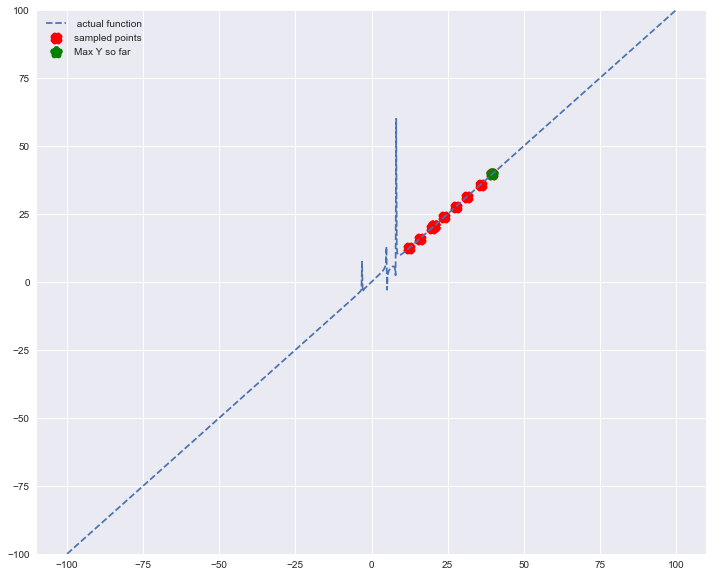

19 domain L
360  domain H
20.554280134 m v 0.0117954628809 point [ 20.64824121]
20.0275501506 m v 0.361595950597 point [ 22.55276382]
21.3156817374 m v 0.222705857094 point [ 24.45728643]
20.9742867507 m v 0.531033439615 point [ 26.36180905]
25.4859770275 m v 0.227229534976 point [ 28.26633166]
26.3349593537 m v 0.439051902878 point [ 30.17085427]
25.2903996023 m v 0.323666791316 point [ 32.07537688]
18.0529214031 m v 0.816397667552 point [ 33.9798995]
34.2447275898 m v 0.0478512278289 point [ 35.88442211]
28.6328792621 m v 0.689702471334 point [ 37.78894472]
37.7107227378 m v 0.0486369806658 point [ 39.69346734]
14.2680195593 m v 0.8575734315 point [ 41.59798995]
0.899371803241 m v 0.99943338865 point [ 43.50251256]
0.00924982746628 m v 0.999999940064 point [ 45.40703518]
1.55130477726e-05 m v 1.0 point [ 47.31155779]
4.24251082959e-09 m v 1.0 point [ 49.2160804]
1.8919555809e-13 m v 1.0 point [ 51.12060302]
1.37581821113e-18 m v 1.0 point [ 53.02512563]
1.63144828983e-24 m v 1.0 poin

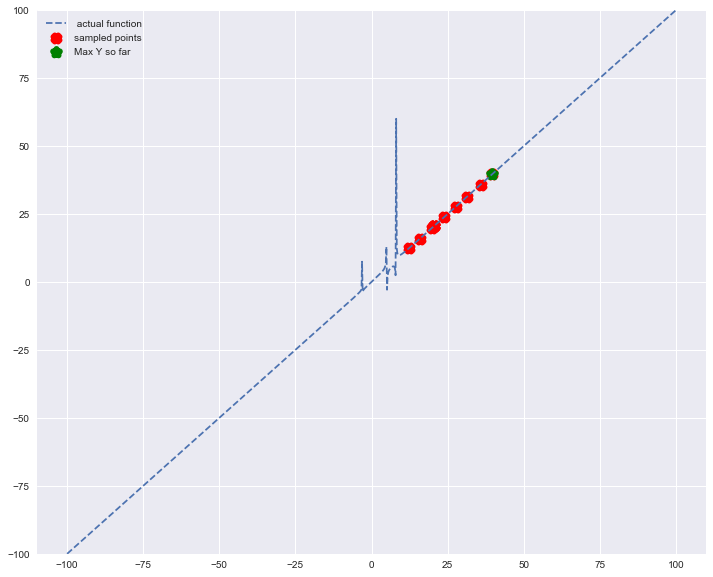

19 domain L
379  domain H
20.5755776765 m v 0.00954577570756 point [ 20.64824121]
20.3284560875 m v 0.345351749086 point [ 22.64824121]
20.6067663331 m v 0.320063450432 point [ 24.64824121]
22.6009930451 m v 0.386540622241 point [ 26.64824121]
24.270625142 m v 0.421385447906 point [ 28.64824121]
28.7829816768 m v 0.199245683499 point [ 30.64824121]
20.1203582029 m v 0.638206877757 point [ 32.64824121]
24.4967899609 m v 0.542511068246 point [ 34.64824121]
32.2476666656 m v 0.293083646302 point [ 36.64824121]
33.4858847127 m v 0.407873734452 point [ 38.64824121]
28.8334642532 m v 0.42209038632 point [ 40.64824121]
3.88787136156 m v 0.989413092201 point [ 42.64824121]
0.0712028880143 m v 0.99999644847 point [ 44.64824121]
0.000176493977808 m v 0.999999999978 point [ 46.64824121]
5.92071310431e-08 m v 1.0 point [ 48.64824121]
2.68799958815e-12 m v 1.0 point [ 50.64824121]
1.65156402749e-17 m v 1.0 point [ 52.64824121]
1.37332292029e-23 m v 1.0 point [ 54.64824121]
1.54547134781e-30 m v 1.0

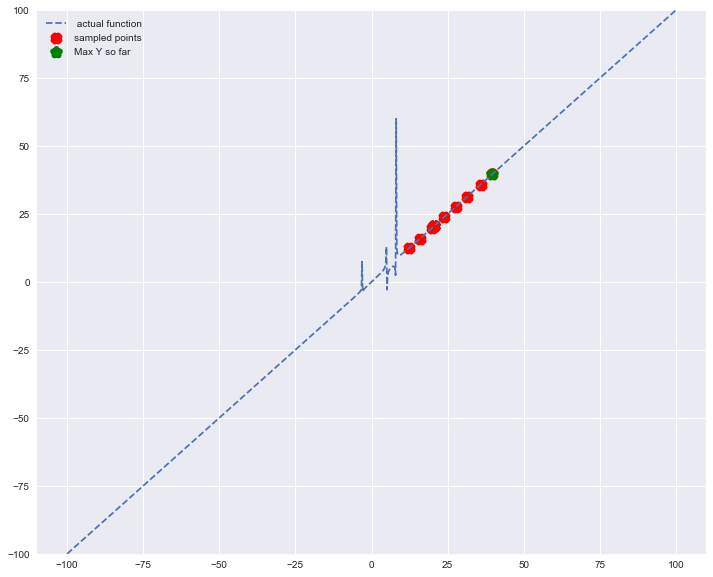

19 domain L
397  domain H
20.5900525353 m v 0.00801677750631 point [ 20.64824121]
20.6209487485 m v 0.32524995654 point [ 22.73869347]
19.9292866323 m v 0.416456752464 point [ 24.82914573]
24.1211613441 m v 0.243984992286 point [ 26.91959799]
23.407690509 m v 0.576337139539 point [ 29.01005025]
29.8833388134 m v 0.0575663931877 point [ 31.10050251]
16.7154790112 m v 0.829933241276 point [ 33.19095477]
31.1598733009 m v 0.196065560009 point [ 35.28140704]
28.8231779966 m v 0.630510668454 point [ 37.3718593]
37.8654804865 m v 0.0638235634631 point [ 39.46231156]
14.9043759148 m v 0.844603451091 point [ 41.55276382]
0.682381174103 m v 0.999673814716 point [ 43.64321608]
0.0035163581105 m v 0.999999991338 point [ 45.73366834]
2.03813614889e-06 m v 1.0 point [ 47.8241206]
1.32874601818e-10 m v 1.0 point [ 49.91457286]
9.74359779069e-16 m v 1.0 point [ 52.00502513]
8.0364696029e-22 m v 1.0 point [ 54.09547739]
7.45555280263e-29 m v 1.0 point [ 56.18592965]
7.77970233167e-37 m v 1.0 point [ 5

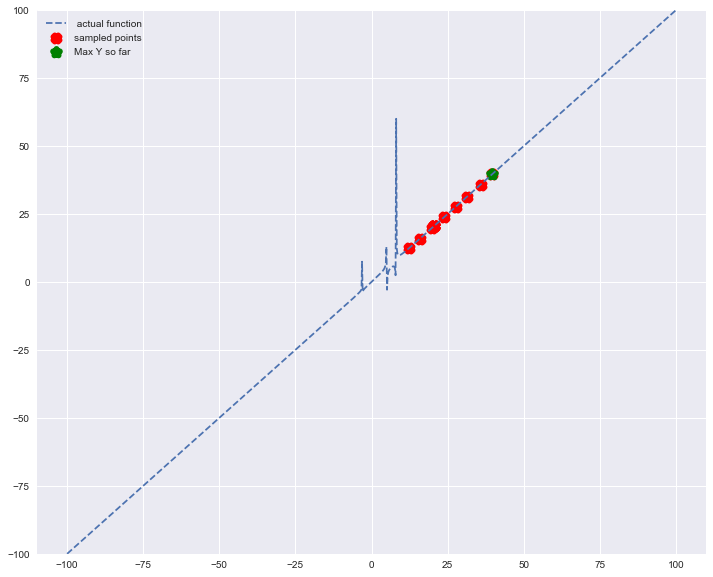

19 domain L
414  domain H
20.6005305571 m v 0.00690997040687 point [ 20.64824121]
20.9004444512 m v 0.302344555262 point [ 22.8241206]
19.3463398375 m v 0.50320421741 point [ 25.]
25.315597358 m v 0.131171633326 point [ 27.1758794]
23.3090814699 m v 0.645569931923 point [ 29.35175879]
29.01682754 m v 0.0844628477873 point [ 31.52763819]
16.6459938347 m v 0.861729146459 point [ 33.70351759]
34.2376795459 m v 0.0477682553665 point [ 35.87939698]
29.5112518561 m v 0.653675737619 point [ 38.05527638]
34.1611386637 m v 0.196222604735 point [ 40.23115578]
5.50235005967 m v 0.978796990751 point [ 42.40703518]
0.0837455744061 m v 0.999995087035 point [ 44.58291457]
0.000119497636817 m v 0.99999999999 point [ 46.75879397]
1.59839712255e-08 m v 1.0 point [ 48.93467337]
2.00418160515e-13 m v 1.0 point [ 51.11055276]
2.35568084217e-19 m v 1.0 point [ 53.28643216]
2.59551069981e-26 m v 1.0 point [ 55.46231156]
2.68074924556e-34 m v 1.0 point [ 57.63819095]
2.59547324637e-43 m v 1.0 point [ 59.81407

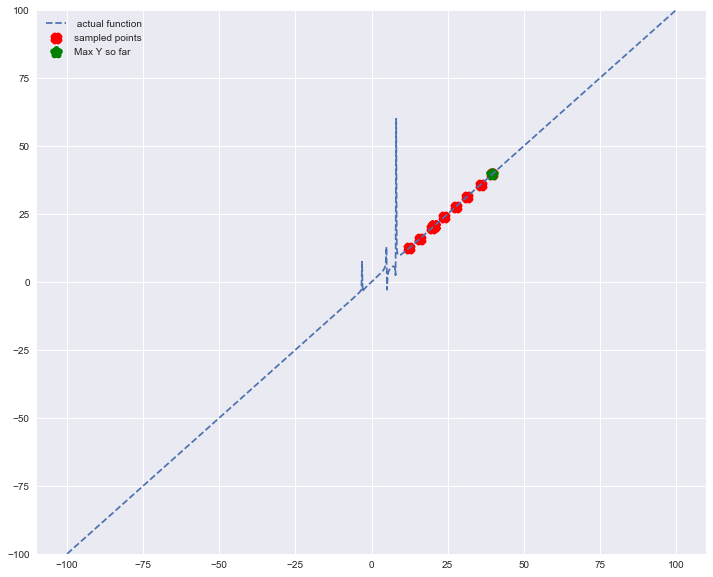

19 domain L
430  domain H
20.6084663437 m v 0.00607170292388 point [ 20.64824121]
21.1623586642 m v 0.27783887959 point [ 22.90452261]
18.8981661838 m v 0.574956689463 point [ 25.16080402]
26.0772714863 m v 0.0646329600025 point [ 27.41708543]
24.0187519949 m v 0.622478327201 point [ 29.67336683]
26.5016077245 m v 0.245291192406 point [ 31.92964824]
19.6766825056 m v 0.754820440896 point [ 34.18592965]
33.2574812005 m v 0.191517662185 point [ 36.44221106]
33.8737564085 m v 0.381199672154 point [ 38.69849246]
24.1220560473 m v 0.594147474708 point [ 40.95477387]
1.544028113 m v 0.998330040468 point [ 43.21105528]
0.00776839673059 m v 0.999999957725 point [ 45.46733668]
3.06595395026e-06 m v 1.0 point [ 47.72361809]
9.49173494005e-11 m v 1.0 point [ 49.9798995]
2.30500115642e-16 m v 1.0 point [ 52.2361809]
4.39078591455e-23 m v 1.0 point [ 54.49246231]
6.56083243667e-31 m v 1.0 point [ 56.74874372]
7.68990896791e-40 m v 1.0 point [ 59.00502513]
7.07015638964e-50 m v 1.0 point [ 61.261306

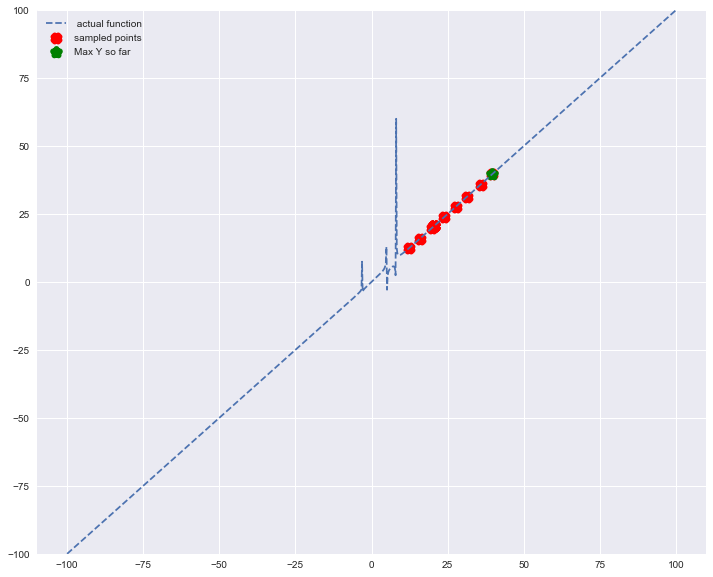

19 domain L
446  domain H
20.6146850143 m v 0.0054148166486 point [ 20.64824121]
21.4186453972 m v 0.251160171443 point [ 22.98492462]
18.5883948769 m v 0.632398820405 point [ 25.32160804]
26.4092851201 m v 0.0488385905128 point [ 27.65829146]
25.403457325 m v 0.519684168474 point [ 29.99497487]
22.9670925112 m v 0.469557683272 point [ 32.33165829]
24.7252104241 m v 0.531537617358 point [ 34.66834171]
30.3083173836 m v 0.480180515087 point [ 37.00502513]
37.6354229714 m v 0.0908799873426 point [ 39.34170854]
13.1699083097 m v 0.878630975008 point [ 41.67839196]
0.313634317958 m v 0.999931093001 point [ 44.01507538]
0.000487358394799 m v 0.999999999834 point [ 46.35175879]
4.93892820708e-08 m v 1.0 point [ 48.68844221]
3.26417670722e-13 m v 1.0 point [ 51.02512563]
1.40692602492e-19 m v 1.0 point [ 53.36180905]
3.95480903996e-27 m v 1.0 point [ 55.69849246]
7.24997362248e-36 m v 1.0 point [ 58.03517588]
8.66770232677e-46 m v 1.0 point [ 60.3718593]
6.75815584934e-57 m v 1.0 point [ 62.7

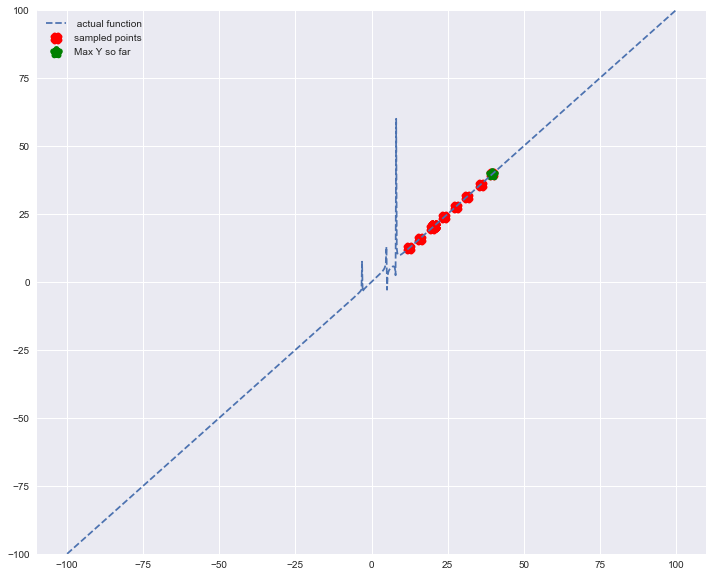

19 domain L
461  domain H
20.6196894751 m v 0.0048861889327 point [ 20.64824121]
21.6500923981 m v 0.224848843577 point [ 23.06030151]
18.4518195533 m v 0.670116250867 point [ 25.47236181]
26.3247449438 m v 0.0826619535363 point [ 27.88442211]
27.024074545 m v 0.375622451657 point [ 30.29648241]
19.6220092966 m v 0.666596769646 point [ 32.70854271]
29.6727439077 m v 0.277117246981 point [ 35.12060302]
28.5280016427 m v 0.669593316948 point [ 37.53266332]
36.5967723684 m v 0.0885106028781 point [ 39.94472362]
5.89364056853 m v 0.975674806298 point [ 42.35678392]
0.0524777448873 m v 0.999998070828 point [ 44.76884422]
2.54835352545e-05 m v 1.0 point [ 47.18090452]
6.74799297419e-10 m v 1.0 point [ 49.59296482]
9.74359779046e-16 m v 1.0 point [ 52.00502513]
7.67173952404e-23 m v 1.0 point [ 54.41708543]
3.29380681497e-31 m v 1.0 point [ 56.82914573]
7.71138120698e-41 m v 1.0 point [ 59.24120603]
9.84455287165e-52 m v 1.0 point [ 61.65326633]
6.85313982634e-64 m v 1.0 point [ 64.06532663]


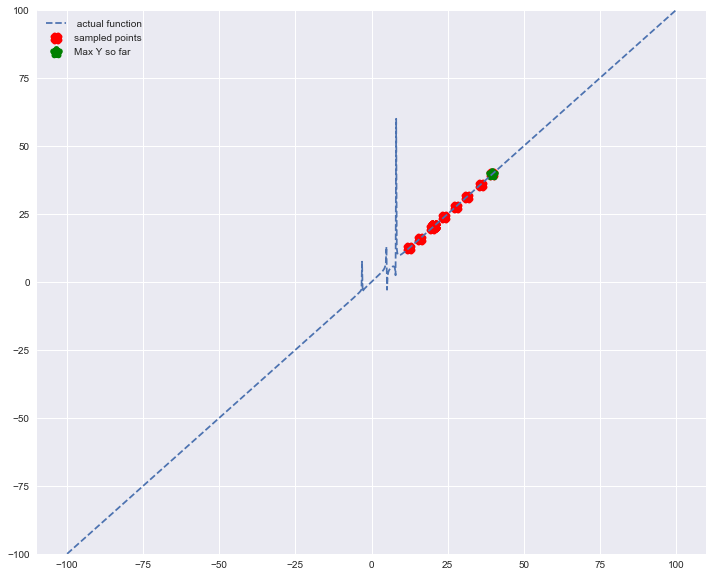

19 domain L
475  domain H
20.6238037124 m v 0.00445159667667 point [ 20.64824121]
21.8550011154 m v 0.199793701394 point [ 23.13065327]
18.4746297037 m v 0.689450587645 point [ 25.61306533]
25.9470157828 m v 0.151687032381 point [ 28.09547739]
28.4716293902 m v 0.232298786524 point [ 30.57788945]
17.2716335833 m v 0.797899004942 point [ 33.06030151]
33.0335421257 m v 0.0955181982461 point [ 35.54271357]
29.3747449068 m v 0.660565918069 point [ 38.02512563]
30.8175155153 m v 0.341366954227 point [ 40.50753769]
2.26158755918 m v 0.996417314914 point [ 42.98994975]
0.00765559415207 m v 0.999999958944 point [ 45.47236181]
1.18965755103e-06 m v 1.0 point [ 47.95477387]
8.48640275778e-12 m v 1.0 point [ 50.43718593]
2.77896930629e-18 m v 1.0 point [ 52.91959799]
4.17736377613e-26 m v 1.0 point [ 55.40201005]
2.88256612376e-35 m v 1.0 point [ 57.88442211]
9.13092332759e-46 m v 1.0 point [ 60.36683417]
1.32772627308e-57 m v 1.0 point [ 62.84924623]
8.86259366089e-71 m v 1.0 point [ 65.33165829

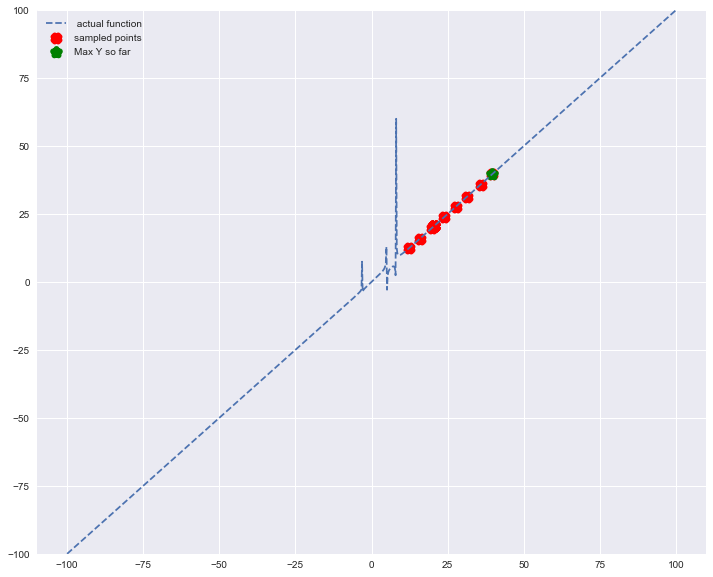

19 domain L
488  domain H
20.6272458622 m v 0.00408799791663 point [ 20.64824121]
22.0329668572 m v 0.176636207835 point [ 23.1959799]
18.6318826775 m v 0.692908033621 point [ 25.74371859]
25.4105031374 m v 0.239374778818 point [ 28.29145729]
29.4627352414 m v 0.121832321468 point [ 30.83919598]
16.2750990429 m v 0.859878144282 point [ 33.38693467]
34.29775802 m v 0.049991279473 point [ 35.93467337]
32.2140640323 m v 0.492529489068 point [ 38.48241206]
22.924018016 m v 0.633249453957 point [ 41.03015075]
0.776667522599 m v 0.999577449085 point [ 43.57788945]
0.00102674764072 m v 0.999999999262 point [ 46.12562814]
5.28690890672e-08 m v 1.0 point [ 48.67336683]
1.06033533386e-13 m v 1.0 point [ 51.22110553]
8.28300420255e-21 m v 1.0 point [ 53.76884422]
2.52020443212e-29 m v 1.0 point [ 56.31658291]
2.98666767547e-39 m v 1.0 point [ 58.86432161]
1.37860952136e-50 m v 1.0 point [ 61.4120603]
2.47855686313e-63 m v 1.0 point [ 63.95979899]
1.73564036449e-77 m v 1.0 point [ 66.50753769]
4.7

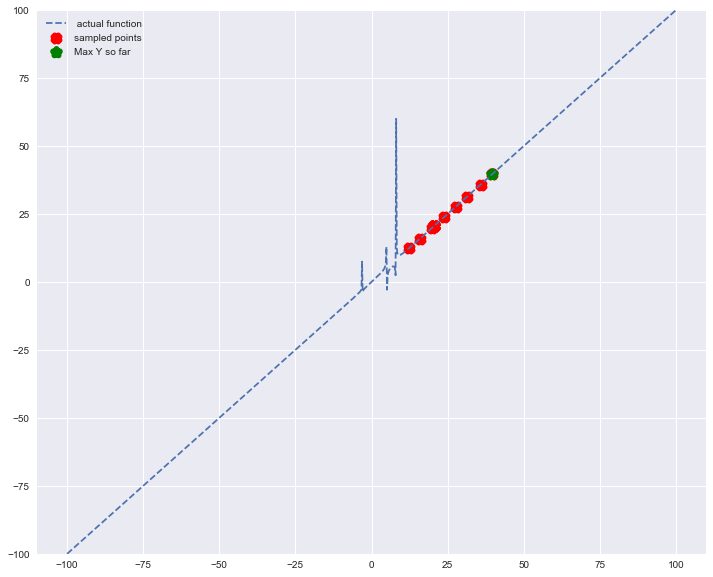

19 domain L
501  domain H
20.6301681736 m v 0.00377931034765 point [ 20.64824121]
22.1966183193 m v 0.154086342388 point [ 23.26130653]
18.9195590739 m v 0.682269043283 point [ 25.87437186]
24.7839196834 m v 0.338951054359 point [ 28.48743719]
29.8833423983 m v 0.0575663931538 point [ 31.10050251]
16.6799750461 m v 0.860844915516 point [ 33.71356784]
33.7112869208 m v 0.142787571217 point [ 36.32663317]
35.6397663039 m v 0.254327480998 point [ 38.93969849]
14.9043759143 m v 0.844603451091 point [ 41.55276382]
0.224390106628 m v 0.999964728411 point [ 44.16582915]
0.000111244751769 m v 0.999999999991 point [ 46.77889447]
1.81489748843e-09 m v 1.0 point [ 49.3919598]
9.74359779038e-16 m v 1.0 point [ 52.00502513]
1.72139787468e-23 m v 1.0 point [ 54.61809045]
1.00077821275e-32 m v 1.0 point [ 57.23115578]
1.91464863803e-43 m v 1.0 point [ 59.84422111]
1.20541057639e-55 m v 1.0 point [ 62.45728643]
2.49732792633e-69 m v 1.0 point [ 65.07035176]
1.70259288876e-84 m v 1.0 point [ 67.6834170

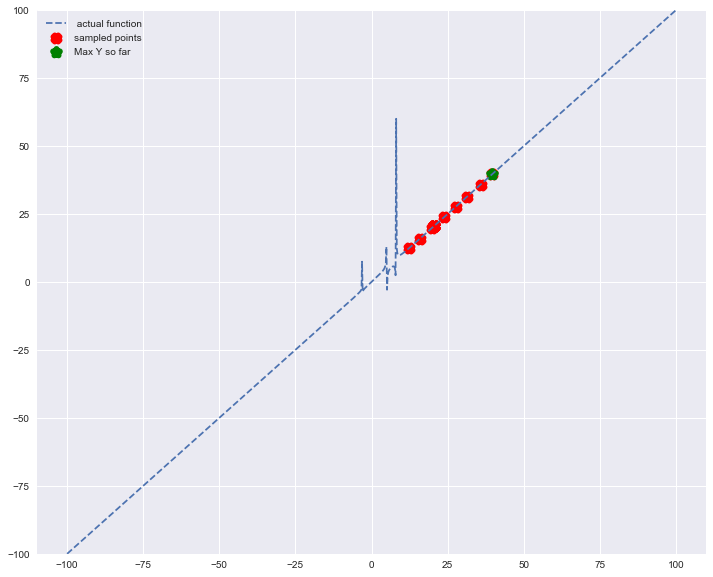

19 domain L
513  domain H
20.6326801391 m v 0.00351396816489 point [ 20.64824121]
22.3331630799 m v 0.134224780699 point [ 23.32160804]
19.2952563981 m v 0.660277187942 point [ 25.99497487]
24.2098293517 m v 0.431386416167 point [ 28.66834171]
29.640851973 m v 0.0519774623336 point [ 31.34170854]
18.2983941959 m v 0.807529521694 point [ 34.01507538]
32.0312835087 m v 0.31423323281 point [ 36.68844221]
37.687558166 m v 0.0855218525203 point [ 39.36180905]
8.87896523088 m v 0.944804660427 point [ 42.03517588]
0.0611830587148 m v 0.999997377698 point [ 44.70854271]
1.18328577583e-05 m v 1.0 point [ 47.38190955]
6.42127623505e-11 m v 1.0 point [ 50.05527638]
9.77744928971e-18 m v 1.0 point [ 52.72864322]
4.1773637761e-26 m v 1.0 point [ 55.40201005]
5.00785246633e-36 m v 1.0 point [ 58.07537688]
1.68450870827e-47 m v 1.0 point [ 60.74874372]
1.58989154656e-60 m v 1.0 point [ 63.42211055]
4.21050555944e-75 m v 1.0 point [ 66.09547739]
3.12876896571e-91 m v 1.0 point [ 68.76884422]
6.5235688

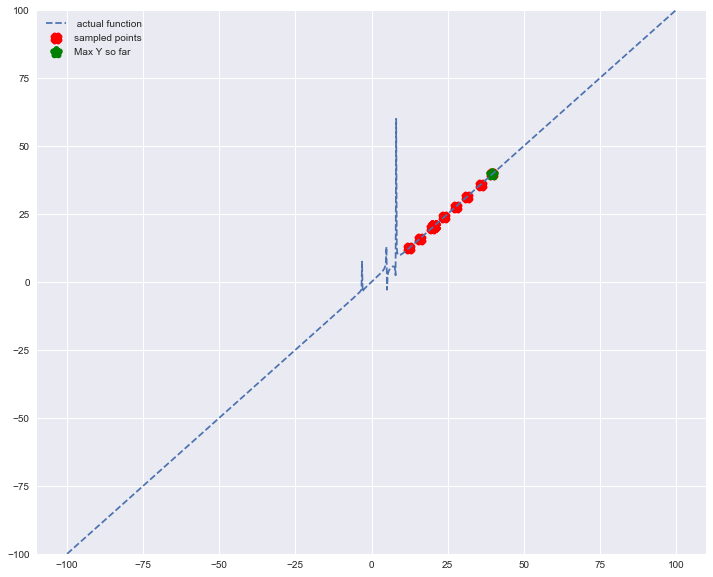

19 domain L
525  domain H
20.6348625185 m v 0.00328344057915 point [ 20.64824121]
22.4540652226 m v 0.115659138969 point [ 23.38190955]
19.7671069697 m v 0.627328300427 point [ 26.11557789]
23.7187068095 m v 0.515244640246 point [ 28.84924623]
28.7600972828 m v 0.0999053465611 point [ 31.58291457]
20.9107664505 m v 0.704229877895 point [ 34.31658291]
30.0803080259 m v 0.502232270503 point [ 37.05025126]
37.424302872 m v 0.0563663110216 point [ 39.7839196]
4.70957724195 m v 0.984465841595 point [ 42.51758794]
0.0143979749883 m v 0.999999854781 point [ 45.25125628]
1.04939532335e-06 m v 1.0 point [ 47.98492462]
1.82325844286e-12 m v 1.0 point [ 50.71859296]
7.55141739105e-20 m v 1.0 point [ 53.45226131]
7.45555280236e-29 m v 1.0 point [ 56.18592965]
1.75469790278e-39 m v 1.0 point [ 58.91959799]
9.84455287153e-52 m v 1.0 point [ 61.65326633]
1.31662096609e-65 m v 1.0 point [ 64.38693467]
4.19755764979e-81 m v 1.0 point [ 67.12060302]
3.19009564721e-98 m v 1.0 point [ 69.85427136]
5.77938

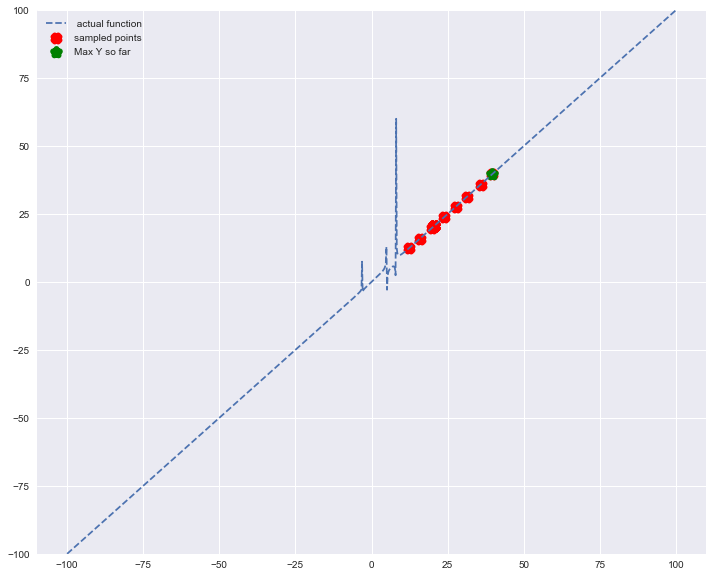

19 domain L
536  domain H
20.6367761843 m v 0.00308129757244 point [ 20.64824121]
22.549947721 m v 0.100076863131 point [ 23.43718593]
20.2728886179 m v 0.58842724172 point [ 26.22613065]
23.4005527138 m v 0.577988964209 point [ 29.01507538]
27.4367210497 m v 0.18434966949 point [ 31.8040201]
23.8716825053 m v 0.572148862942 point [ 34.59296482]
28.7972453855 m v 0.633506650456 point [ 37.38190955]
34.7697778809 m v 0.169010323938 point [ 40.17085427]
2.37790514539 m v 0.996039331259 point [ 42.95979899]
0.00335851512335 m v 0.999999992098 point [ 45.74874372]
9.7074036516e-08 m v 1.0 point [ 48.53768844]
5.74171395212e-14 m v 1.0 point [ 51.32663317]
6.94964459928e-22 m v 1.0 point [ 54.11557789]
1.721338243e-31 m v 1.0 point [ 56.90452261]
8.72473848811e-43 m v 1.0 point [ 59.69346734]
9.04942944158e-56 m v 1.0 point [ 62.48241206]
1.92075758465e-70 m v 1.0 point [ 65.27135678]
8.34269745392e-87 m v 1.0 point [ 68.06030151]
7.41520241557e-105 m v 1.0 point [ 70.84924623]
1.3487209571

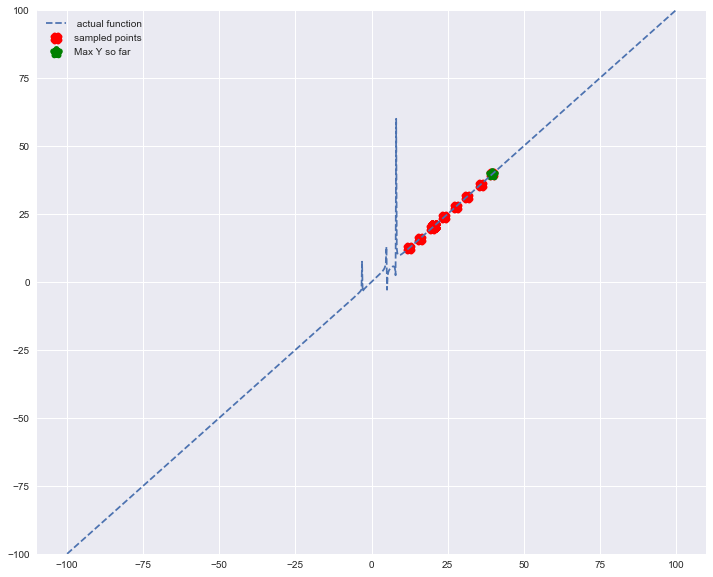

19 domain L
546  domain H
20.6384678877 m v 0.00290260073717 point [ 20.64824121]
22.623824501 m v 0.0873226582404 point [ 23.48743719]
20.7826477475 m v 0.546800961165 point [ 26.32663317]
23.2583809203 m v 0.61920538955 point [ 29.16582915]
25.8895780292 m v 0.285035988674 point [ 32.00502513]
26.7221749914 m v 0.432482258856 point [ 34.84422111]
28.5005756826 m v 0.68794431714 point [ 37.68341709]
30.6126003773 m v 0.349913636181 point [ 40.52261307]
1.17368906123 m v 0.999035042452 point [ 43.36180905]
0.000803203733621 m v 0.999999999548 point [ 46.20100503]
9.76509970168e-09 m v 1.0 point [ 49.04020101]
2.10909643615e-15 m v 1.0 point [ 51.87939698]
8.09254163629e-24 m v 1.0 point [ 54.71859296]
5.51622783852e-34 m v 1.0 point [ 57.55778894]
6.67987287183e-46 m v 1.0 point [ 60.39698492]
1.43702044587e-59 m v 1.0 point [ 63.2361809]
5.49194837025e-75 m v 1.0 point [ 66.07537688]
3.72871073188e-92 m v 1.0 point [ 68.91457286]
4.49738107542e-111 m v 1.0 point [ 71.75376884]
9.63672

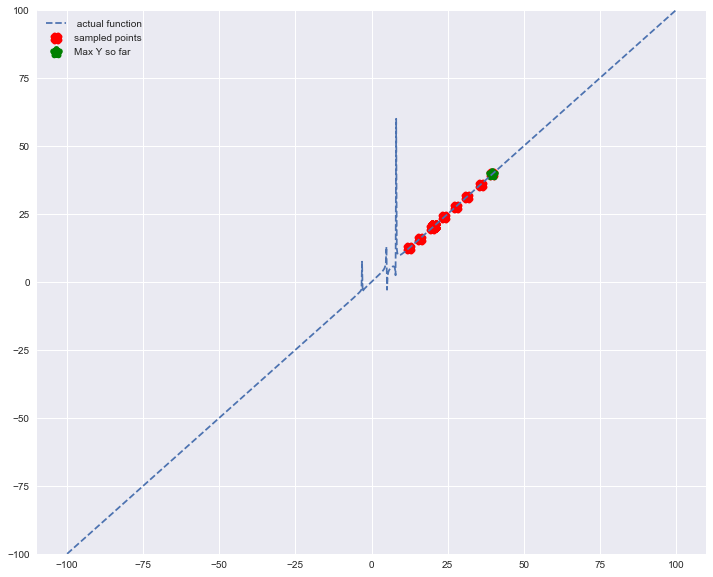

19 domain L
556  domain H
20.6399741294 m v 0.00274349446246 point [ 20.64824121]
22.6843248165 m v 0.0760936192012 point [ 23.53768844]
21.3288106044 m v 0.500257453061 point [ 26.42713568]
23.2793980275 m v 0.642779049503 point [ 29.31658291]
24.1245365916 m v 0.397734497428 point [ 32.20603015]
29.4219683 m v 0.290662068638 point [ 35.09547739]
29.2067665793 m v 0.668671109078 point [ 37.98492462]
25.3906303948 m v 0.55065683384 point [ 40.87437186]
0.534347549425 m v 0.999799986038 point [ 43.7638191]
0.000173415856114 m v 0.999999999979 point [ 46.65326633]
8.65797839741e-10 m v 1.0 point [ 49.54271357]
6.64970612772e-17 m v 1.0 point [ 52.4321608]
7.85681722842e-26 m v 1.0 point [ 55.32160804]
1.4280686666e-36 m v 1.0 point [ 58.21105528]
3.99309619703e-49 m v 1.0 point [ 61.10050251]
1.71762636515e-63 m v 1.0 point [ 63.98994975]
1.13659532459e-79 m v 1.0 point [ 66.87939698]
1.15702108965e-97 m v 1.0 point [ 69.76884422]
1.81190293105e-117 m v 1.0 point [ 72.65829146]
4.3650258

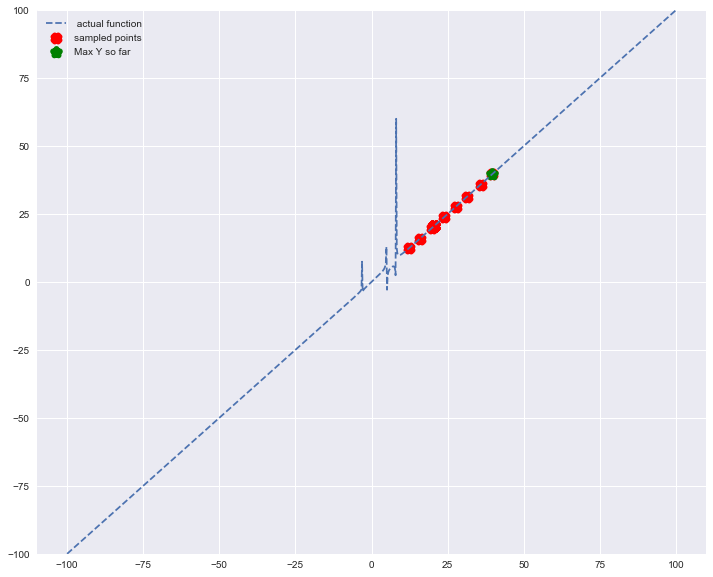

19 domain L
565  domain H
20.6413238228 m v 0.00260092458824 point [ 20.64824121]
22.7268848165 m v 0.0674219127285 point [ 23.58291457]
21.8416759431 m v 0.45513062735 point [ 26.51758794]
23.4471550097 m v 0.64774393779 point [ 29.45226131]
22.45529666 m v 0.500724375253 point [ 32.38693467]
31.4954592265 m v 0.17772467301 point [ 35.32160804]
30.628886581 m v 0.59121081031 point [ 38.25628141]
20.3714280588 m v 0.71009221799 point [ 41.19095477]
0.245620638419 m v 0.999957738298 point [ 44.12562814]
3.99899132437e-05 m v 0.999999999999 point [ 47.06030151]
8.78009981078e-11 m v 1.0 point [ 49.99497487]
2.5996182799e-18 m v 1.0 point [ 52.92964824]
1.03796053435e-27 m v 1.0 point [ 55.86432161]
5.58873129401e-39 m v 1.0 point [ 58.79899497]
4.05795051861e-52 m v 1.0 point [ 61.73366834]
3.97339182963e-67 m v 1.0 point [ 64.66834171]
5.24659053305e-84 m v 1.0 point [ 67.60301508]
9.34230577375e-103 m v 1.0 point [ 70.53768844]
2.24332457289e-123 m v 1.0 point [ 73.47236181]
7.26425831

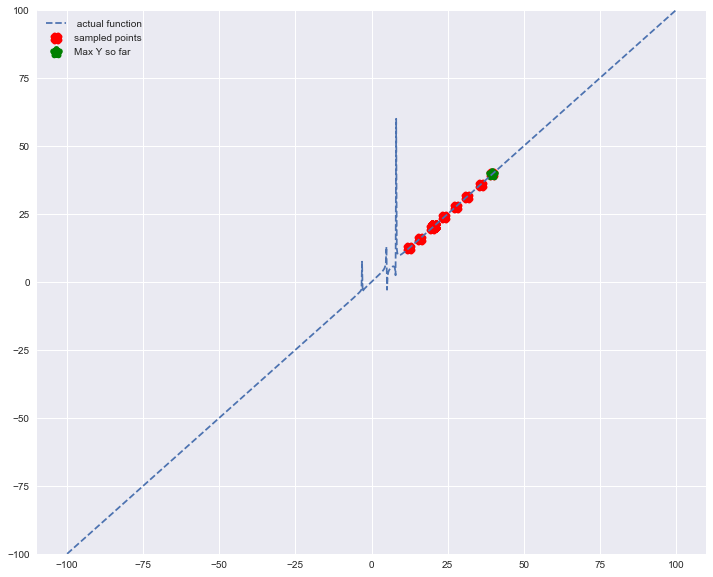

19 domain L
574  domain H
20.6425401681 m v 0.00247244044923 point [ 20.64824121]
22.7577962808 m v 0.0602161956569 point [ 23.6281407]
22.3652618128 m v 0.407919846957 point [ 26.6080402]
23.7557529602 m v 0.637049027256 point [ 29.5879397]
20.814129946 m v 0.59814988729 point [ 32.5678392]
33.0619654386 m v 0.0940708442886 point [ 35.54773869]
32.5565041308 m v 0.470167377754 point [ 38.52763819]
15.5532769032 m v 0.830798854016 point [ 41.50753769]
0.105750192572 m v 0.99999216603 point [ 44.48743719]
8.4885924692e-06 m v 1.0 point [ 47.46733668]
8.03835252654e-12 m v 1.0 point [ 50.44723618]
8.97995429985e-20 m v 1.0 point [ 53.42713568]
1.18346907476e-29 m v 1.0 point [ 56.40703518]
1.8399897792e-41 m v 1.0 point [ 59.38693467]
3.37481224873e-55 m v 1.0 point [ 62.36683417]
7.30229766414e-71 m v 1.0 point [ 65.34673367]
1.86399677656e-88 m v 1.0 point [ 68.32663317]
5.61314797304e-108 m v 1.0 point [ 71.30653266]
1.99408439442e-129 m v 1.0 point [ 74.28643216]
8.35711325382e-153 m

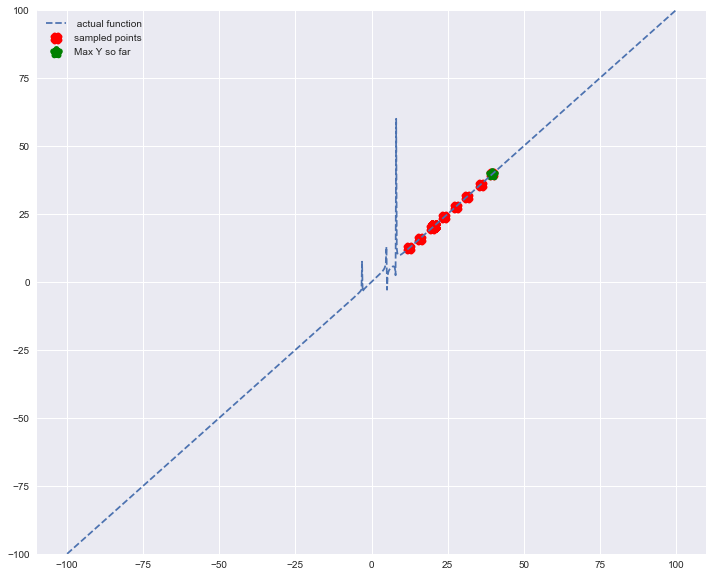

19 domain L
582  domain H
20.6436419969 m v 0.00235605283048 point [ 20.64824121]
22.7752769415 m v 0.0551146595209 point [ 23.66834171]
22.8320604557 m v 0.365032068677 point [ 26.68844221]
24.1416234223 m v 0.614788769551 point [ 29.70854271]
19.4607791875 m v 0.675718160204 point [ 32.72864322]
33.9415618418 m v 0.0539849109577 point [ 35.74874372]
34.4102819204 m v 0.343635842865 point [ 38.76884422]
11.7347962562 m v 0.903620661684 point [ 41.78894472]
0.0473259293878 m v 0.999998431014 point [ 44.80904523]
1.99668242173e-06 m v 1.0 point [ 47.82914573]
8.80882420076e-13 m v 1.0 point [ 50.84924623]
4.06373499106e-21 m v 1.0 point [ 53.86934673]
1.96033953959e-31 m v 1.0 point [ 56.88944724]
9.88862041061e-44 m v 1.0 point [ 59.90954774]
5.21601219545e-58 m v 1.0 point [ 62.92964824]
2.87700075279e-74 m v 1.0 point [ 65.94974874]
1.65935702516e-92 m v 1.0 point [ 68.96984925]
1.00077900658e-112 m v 1.0 point [ 71.98994975]
6.31153536762e-135 m v 1.0 point [ 75.01005025]
4.16227086

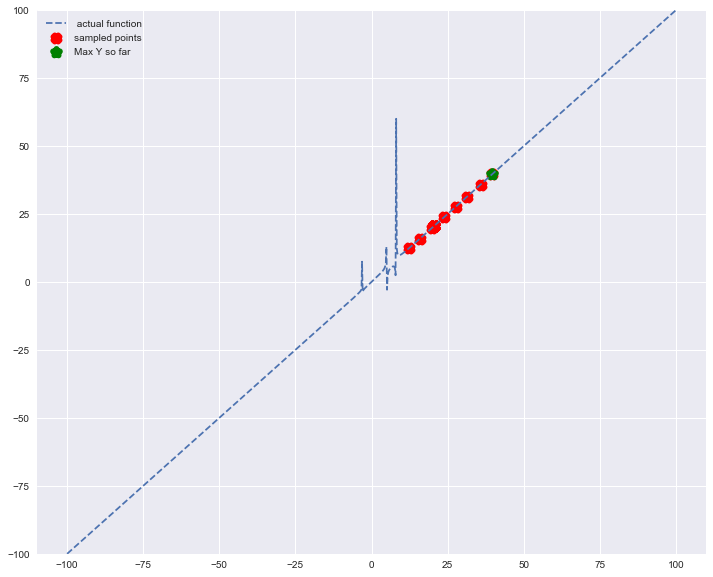

19 domain L
590  domain H
20.6446447545 m v 0.00225013023871 point [ 20.64824121]
22.7831777899 m v 0.051296892807 point [ 23.70854271]
23.2932450722 m v 0.322062541594 point [ 26.76884422]
24.6210327317 m v 0.581385415897 point [ 29.82914573]
18.2768389708 m v 0.74193908522 point [ 32.88944724]
34.3075290521 m v 0.0510959020827 point [ 35.94974874]
36.0976085411 m v 0.219668044043 point [ 39.01005025]
8.51114804354 m v 0.949281113525 point [ 42.07035176]
0.0201121018169 m v 0.999999716642 point [ 45.13065327]
4.39902546537e-07 m v 1.0 point [ 48.19095477]
8.90379638148e-14 m v 1.0 point [ 51.25125628]
1.66768243081e-22 m v 1.0 point [ 54.31155779]
2.89048604079e-33 m v 1.0 point [ 57.3718593]
4.63604655382e-46 m v 1.0 point [ 60.4321608]
6.88088167211e-61 m v 1.0 point [ 63.49246231]
9.45060865848e-78 m v 1.0 point [ 66.55276382]
1.20114339967e-96 m v 1.0 point [ 69.61306533]
1.4126979914e-117 m v 1.0 point [ 72.67336683]
1.53752853752e-140 m v 1.0 point [ 75.73366834]
1.54851862074e-

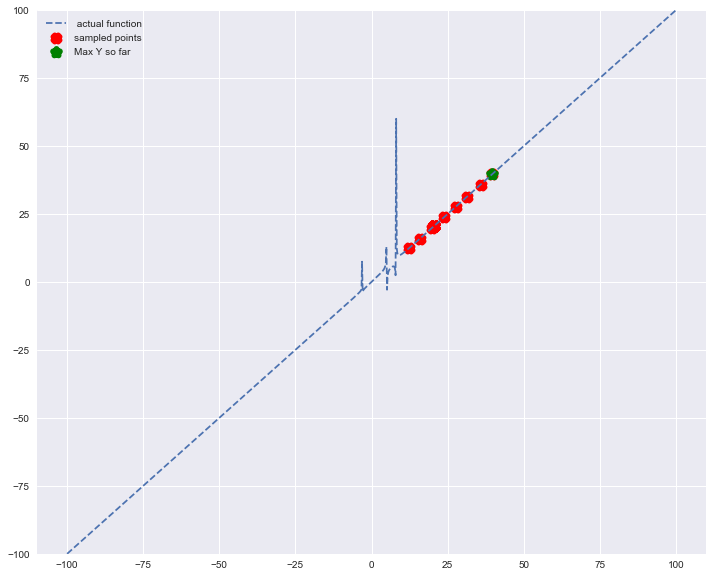

19 domain L
598  domain H
20.645561228 m v 0.00215332195032 point [ 20.64824121]
22.7813945114 m v 0.0488083808015 point [ 23.74874372]
23.7422571173 m v 0.279787987517 point [ 26.84924623]
25.1783269568 m v 0.53811891203 point [ 29.94974874]
17.3224502977 m v 0.795042125175 point [ 33.05025126]
34.1789924768 m v 0.0855177992636 point [ 36.15075377]
37.3367885242 m v 0.11889359405 point [ 39.25125628]
5.93385680619 m v 0.975341771729 point [ 42.35175879]
0.00811626056068 m v 0.999999953854 point [ 45.45226131]
9.07774811542e-08 m v 1.0 point [ 48.55276382]
8.30116180579e-15 m v 1.0 point [ 51.65326633]
6.20637555025e-24 m v 1.0 point [ 54.75376884]
3.79381058615e-35 m v 1.0 point [ 57.85427136]
1.89605817031e-48 m v 1.0 point [ 60.95477387]
7.74758038244e-64 m v 1.0 point [ 64.05527638]
2.58832582136e-81 m v 1.0 point [ 67.15577889]
7.06985032502e-101 m v 1.0 point [ 70.25628141]
1.57884652128e-122 m v 1.0 point [ 73.35678392]
2.88275696492e-146 m v 1.0 point [ 76.45728643]
4.303428246

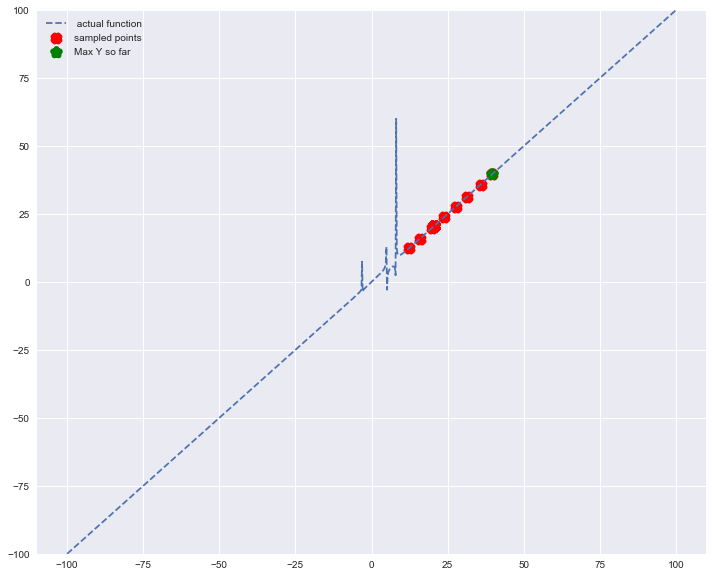

19 domain L
605  domain H
20.6464020947 m v 0.00206450010434 point [ 20.64824121]
22.7718444793 m v 0.0477502757467 point [ 23.7839196]
24.1201569923 m v 0.243983101362 point [ 26.91959799]
25.7145322378 m v 0.493490652558 point [ 30.05527638]
16.7154738455 m v 0.829933241226 point [ 33.19095477]
33.7112869319 m v 0.142787571217 point [ 36.32663317]
37.8654804873 m v 0.0638235634631 point [ 39.46231156]
4.18964468303 m v 0.987706031278 point [ 42.59798995]
0.00351635811034 m v 0.999999991338 point [ 45.73366834]
2.16248951247e-08 m v 1.0 point [ 48.86934673]
9.74359779025e-16 m v 1.0 point [ 52.00502513]
3.21654035979e-25 m v 1.0 point [ 55.14070352]
7.77970233131e-37 m v 1.0 point [ 58.27638191]
1.37860952133e-50 m v 1.0 point [ 61.4120603]
1.78987987618e-66 m v 1.0 point [ 64.54773869]
1.70259288874e-84 m v 1.0 point [ 67.68341709]
1.18659376851e-104 m v 1.0 point [ 70.81909548]
6.05895364225e-127 m v 1.0 point [ 73.95477387]
2.26671810938e-151 m v 1.0 point [ 77.09045226]
6.21300520

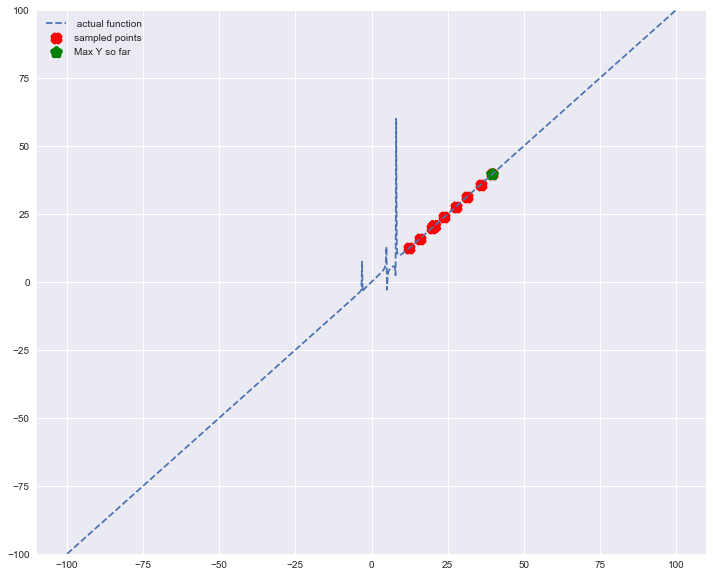

19 domain L
612  domain H
20.6471763401 m v 0.0019827155593 point [ 20.64824121]
22.7548195126 m v 0.0477567370429 point [ 23.81909548]
24.4798187011 m v 0.20982769083 point [ 26.98994975]
26.2802466693 m v 0.443968315619 point [ 30.16080402]
16.3490287725 m v 0.853652980239 point [ 33.33165829]
32.984104278 m v 0.219658647007 point [ 36.50251256]
37.7568469488 m v 0.0479649517516 point [ 39.67336683]
2.86986039933 m v 0.994231131655 point [ 42.84422111]
0.00146431453575 m v 0.999999998498 point [ 46.01507538]
4.8996647557e-09 m v 1.0 point [ 49.18592965]
1.07505644341e-16 m v 1.0 point [ 52.35678392]
1.54678165401e-26 m v 1.0 point [ 55.52763819]
1.45935047318e-38 m v 1.0 point [ 58.69849246]
9.02865460388e-53 m v 1.0 point [ 61.86934673]
3.66285157012e-69 m v 1.0 point [ 65.04020101]
9.74425063421e-88 m v 1.0 point [ 68.21105528]
1.69984928526e-108 m v 1.0 point [ 71.38190955]
1.94448784602e-131 m v 1.0 point [ 74.55276382]
1.45858886544e-156 m v 1.0 point [ 77.72361809]
7.1745290750

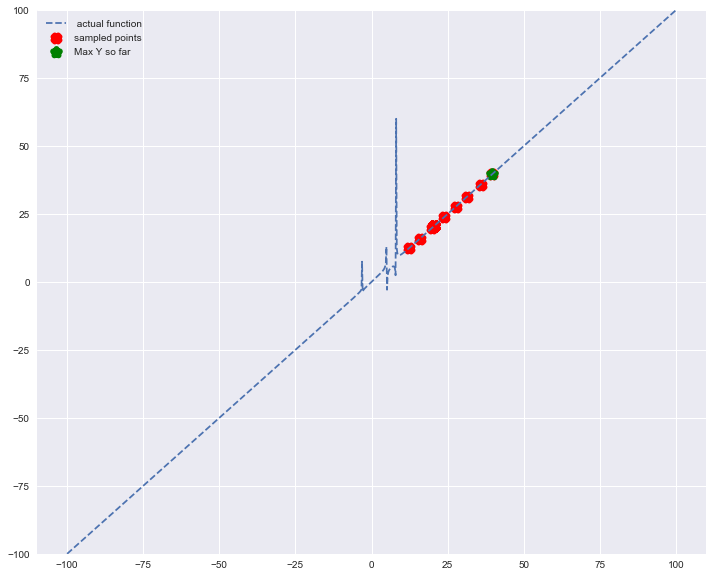

19 domain L
619  domain H
20.6478915799 m v 0.00190716384253 point [ 20.64824121]
22.7303364349 m v 0.0488410706552 point [ 23.85427136]
24.8174364888 m v 0.177824908631 point [ 27.06030151]
26.8588579657 m v 0.391105043586 point [ 30.26633166]
16.2411564873 m v 0.86605114814 point [ 33.47236181]
32.0857479028 m v 0.308922939921 point [ 36.67839196]
36.9545145641 m v 0.0737882396412 point [ 39.88442211]
1.90714815906 m v 0.997452245148 point [ 43.09045226]
0.000586110896077 m v 0.999999999759 point [ 46.29648241]
1.05588153613e-09 m v 1.0 point [ 49.50251256]
1.11499940066e-17 m v 1.0 point [ 52.70854271]
6.9017317121e-28 m v 1.0 point [ 55.91457286]
2.50417982963e-40 m v 1.0 point [ 59.12060302]
5.32594839208e-55 m v 1.0 point [ 62.32663317]
6.63976020868e-72 m v 1.0 point [ 65.53266332]
4.85212340235e-91 m v 1.0 point [ 68.73869347]
2.07842941726e-112 m v 1.0 point [ 71.94472362]
5.21870471613e-136 m v 1.0 point [ 75.15075377]
7.68093639717e-162 m v 1.0 point [ 78.35678392]
6.6265825

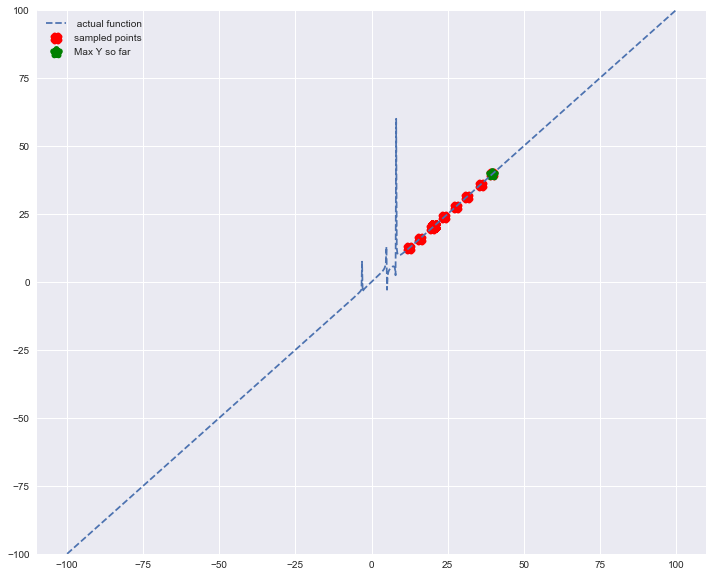

19 domain L
625  domain H
20.6485543119 m v 0.00183715859872 point [ 20.64824121]
22.7034458777 m v 0.0506345071033 point [ 23.88442211]
25.0866118763 m v 0.152471249563 point [ 27.12060302]
27.3517753805 m v 0.344419169018 point [ 30.35678392]
16.3618066005 m v 0.867627502613 point [ 33.59296482]
31.2553055914 m v 0.389217086205 point [ 36.82914573]
35.7150776019 m v 0.126829832562 point [ 40.06532663]
1.31155350584 m v 0.998795042528 point [ 43.30150754]
0.000259087530688 m v 0.999999999953 point [ 46.53768844]
2.72247331069e-10 m v 1.0 point [ 49.77386935]
1.52169156389e-18 m v 1.0 point [ 53.01005025]
4.52413436034e-29 m v 1.0 point [ 56.24623116]
7.15468001457e-42 m v 1.0 point [ 59.48241206]
6.0185350677e-57 m v 1.0 point [ 62.71859296]
2.69300546579e-74 m v 1.0 point [ 65.95477387]
6.40957942865e-94 m v 1.0 point [ 69.19095477]
8.11461075078e-116 m v 1.0 point [ 72.42713568]
5.46451609734e-140 m v 1.0 point [ 75.66331658]
1.9574090261e-166 m v 1.0 point [ 78.89949749]
3.72955763

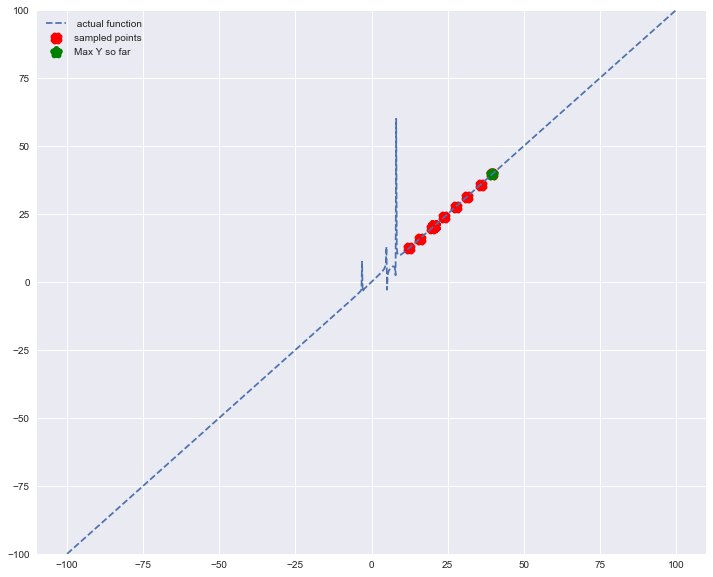

19 domain L
631  domain H
20.6491701134 m v 0.0017721106792 point [ 20.64824121]
22.6711498426 m v 0.0532274914534 point [ 23.91457286]
25.3350098551 m v 0.129334306184 point [ 27.18090452]
27.8299321637 m v 0.297653189388 point [ 30.44723618]
16.6799740531 m v 0.860844915511 point [ 33.71356784]
30.4385439593 m v 0.467634003291 point [ 36.9798995]
34.0015708608 m v 0.203338278882 point [ 40.24623116]
0.882097640174 m v 0.999454944983 point [ 43.51256281]
0.000111244751767 m v 0.999999999991 point [ 46.77889447]
6.76585267446e-11 m v 1.0 point [ 50.04522613]
1.98444228333e-19 m v 1.0 point [ 53.31155779]
2.80690246723e-30 m v 1.0 point [ 56.57788945]
1.914648638e-43 m v 1.0 point [ 59.84422111]
6.29830614511e-59 m v 1.0 point [ 63.11055276]
9.99151537997e-77 m v 1.0 point [ 66.37688442]
7.64384497305e-97 m v 1.0 point [ 69.64321608]
2.82010510287e-119 m v 1.0 point [ 72.90954774]
5.01754912439e-144 m v 1.0 point [ 76.1758794]
4.3051757632e-171 m v 1.0 point [ 79.44221106]
1.78140659157

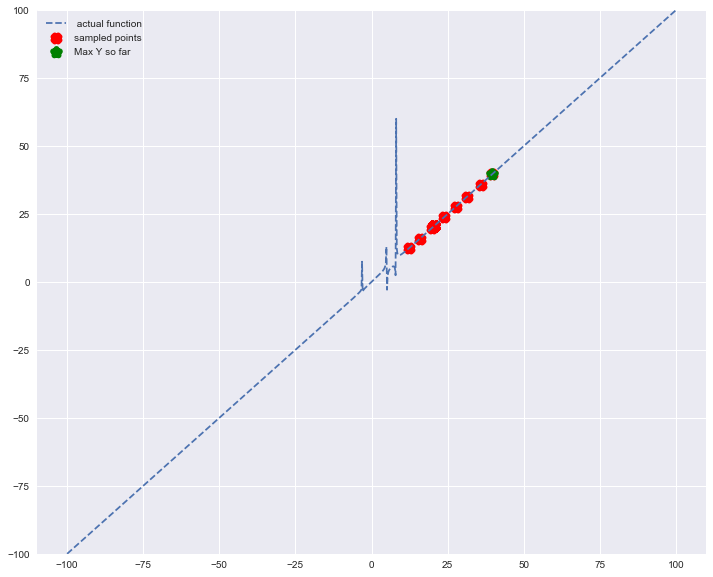

19 domain L
637  domain H
20.649743799 m v 0.00171151152146 point [ 20.64824121]
22.6335072592 m v 0.0566188894523 point [ 23.94472362]
25.5608394407 m v 0.108674807297 point [ 27.24120603]
28.2820044583 m v 0.251960553516 point [ 30.53768844]
17.1912299824 m v 0.845720682689 point [ 33.83417085]
29.6997046021 m v 0.53943390647 point [ 37.13065327]
31.8747831979 m v 0.296557406836 point [ 40.42713568]
0.580197430166 m v 0.999764189284 point [ 43.72361809]
4.63958196543e-05 m v 0.999999999998 point [ 47.0201005]
1.62066000027e-11 m v 1.0 point [ 50.31658291]
2.47292048179e-20 m v 1.0 point [ 53.61306533]
1.64828974571e-31 m v 1.0 point [ 56.90954774]
4.79912574187e-45 m v 1.0 point [ 60.20603015]
6.10373778582e-61 m v 1.0 point [ 63.50251256]
3.39105453693e-79 m v 1.0 point [ 66.79899497]
8.22960228829e-100 m v 1.0 point [ 70.09547739]
8.72424971115e-123 m v 1.0 point [ 73.3919598]
4.04001050972e-148 m v 1.0 point [ 76.68844221]
8.17225800135e-176 m v 1.0 point [ 79.98492462]
7.22115737

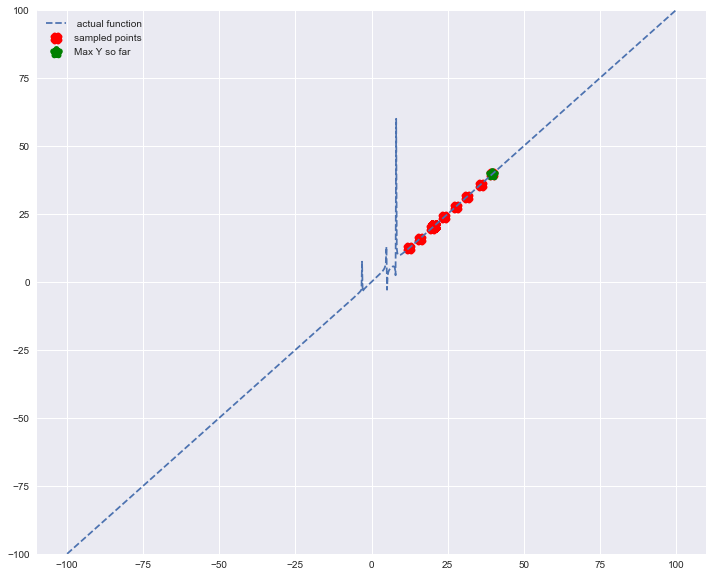

19 domain L
642  domain H
20.6502795464 m v 0.00165491982616 point [ 20.64824121]
22.5981027713 m v 0.0600521238756 point [ 23.96984925]
25.7306575272 m v 0.0935213783168 point [ 27.29145729]
28.6308116948 m v 0.215533336953 point [ 30.61306533]
17.7581728284 m v 0.826782109379 point [ 33.93467337]
29.1862060311 m v 0.591204906178 point [ 37.25628141]
29.8447644359 m v 0.381517969184 point [ 40.57788945]
0.402318662708 m v 0.999886615124 point [ 43.89949749]
2.18941224166e-05 m v 1.0 point [ 47.22110553]
4.78944845085e-12 m v 1.0 point [ 50.54271357]
4.21153675994e-21 m v 1.0 point [ 53.86432161]
1.48865072384e-32 m v 1.0 point [ 57.18592965]
2.11515478849e-46 m v 1.0 point [ 60.50753769]
1.20806032494e-62 m v 1.0 point [ 63.82914573]
2.77352581724e-81 m v 1.0 point [ 67.15075377]
2.55960487665e-102 m v 1.0 point [ 70.47236181]
9.49534545698e-126 m v 1.0 point [ 73.79396985]
1.41594288414e-151 m v 1.0 point [ 77.11557789]
8.48746166104e-180 m v 1.0 point [ 80.43718593]
2.04506464402e-2

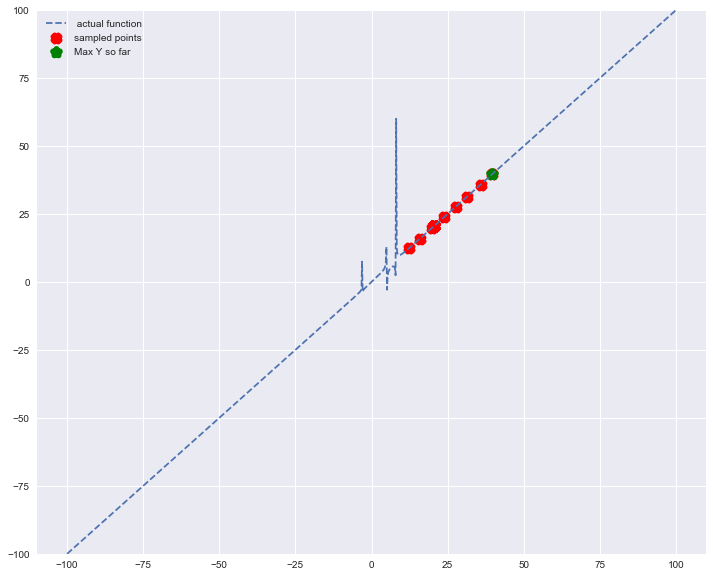

19 domain L
647  domain H
20.6507809985 m v 0.00160195079265 point [ 20.64824121]
22.5590857226 m v 0.0640332364059 point [ 23.99497487]
25.8829433594 m v 0.0803725196291 point [ 27.34170854]
28.9476699877 m v 0.181298116663 point [ 30.68844221]
18.4448530195 m v 0.802153324211 point [ 34.03517588]
28.7972453939 m v 0.633506650456 point [ 37.38190955]
27.6379475793 m v 0.468443170445 point [ 40.72864322]
0.274693137052 m v 0.999947141794 point [ 44.07537688]
1.0125181782e-05 m v 1.0 point [ 47.42211055]
1.3796701028e-12 m v 1.0 point [ 50.76884422]
6.9496445992e-22 m v 1.0 point [ 54.11557789]
1.29409110314e-33 m v 1.0 point [ 57.46231156]
8.90803717739e-48 m v 1.0 point [ 60.80904523]
2.26680469712e-64 m v 1.0 point [ 64.15577889]
2.13236281475e-83 m v 1.0 point [ 67.50251256]
7.41520241548e-105 m v 1.0 point [ 70.84924623]
9.53234680336e-129 m v 1.0 point [ 74.1959799]
4.52993084118e-155 m v 1.0 point [ 77.54271357]
7.95789532907e-184 m v 1.0 point [ 80.88944724]
5.16796765654e-215 m

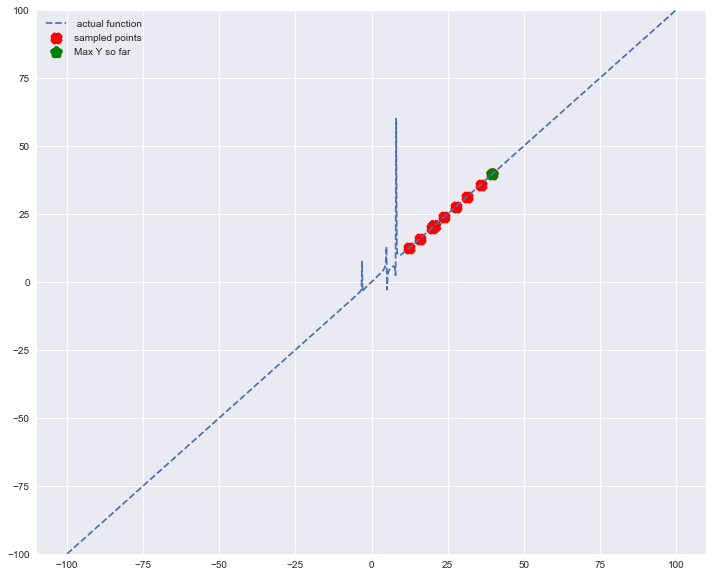

19 domain L
652  domain H
20.6512513461 m v 0.00155226735761 point [ 20.64824121]
22.5165136448 m v 0.0685570538463 point [ 24.0201005]
26.0170501532 m v 0.0693332054666 point [ 27.3919598]
29.2267732539 m v 0.149872746185 point [ 30.7638191]
19.2411491224 m v 0.771953085958 point [ 34.13567839]
28.556668196 m v 0.66477167107 point [ 37.50753769]
25.3117824357 m v 0.553422018469 point [ 40.87939698]
0.184675201196 m v 0.99997610894 point [ 44.25125628]
4.58885898792e-06 m v 1.0 point [ 47.62311558]
3.87401380041e-13 m v 1.0 point [ 50.99497487]
1.11115885391e-22 m v 1.0 point [ 54.36683417]
1.08280355356e-34 m v 1.0 point [ 57.73869347]
3.58493864392e-49 m v 1.0 point [ 61.11055276]
4.03248086678e-66 m v 1.0 point [ 64.48241206]
1.54106670406e-85 m v 1.0 point [ 67.85427136]
2.00091708573e-107 m v 1.0 point [ 71.22613065]
8.82663730904e-132 m v 1.0 point [ 74.59798995]
1.32287863971e-158 m v 1.0 point [ 77.96984925]
6.73601832598e-188 m v 1.0 point [ 81.34170854]
1.16531959591e-219 m v

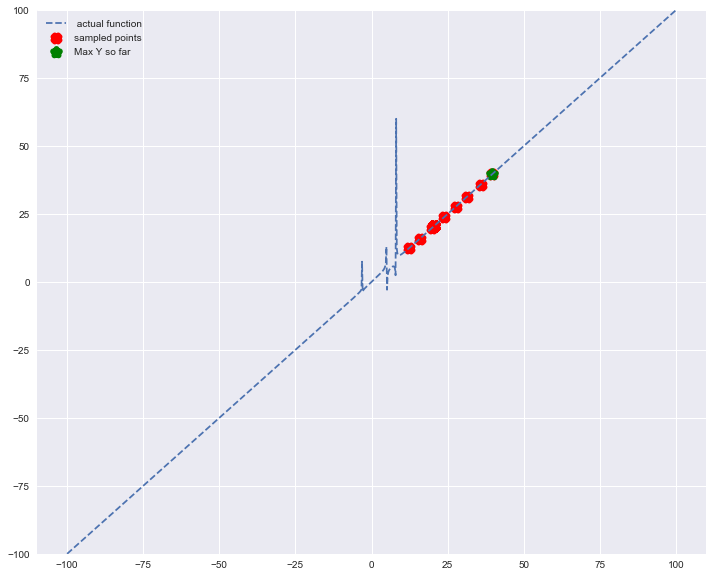

19 domain L
657  domain H
20.6516933964 m v 0.00150557301504 point [ 20.64824121]
22.4704509453 m v 0.0736170839584 point [ 24.04522613]
26.1324615832 m v 0.0604917445939 point [ 27.44221106]
29.4627421014 m v 0.121832321265 point [ 30.83919598]
20.1349142249 m v 0.736374338897 point [ 34.2361809]
28.4817132297 m v 0.683874632454 point [ 37.63316583]
22.9240180156 m v 0.633249453957 point [ 41.03015075]
0.122250998547 m v 0.999989530544 point [ 44.42713568]
2.03813614879e-06 m v 1.0 point [ 47.8241206]
1.06033533384e-13 m v 1.0 point [ 51.22110553]
1.72139787465e-23 m v 1.0 point [ 54.61809045]
8.72061825579e-36 m v 1.0 point [ 58.01507538]
1.37860952133e-50 m v 1.0 point [ 61.4120603]
6.80085093973e-68 m v 1.0 point [ 64.80904523]
1.04691934137e-87 m v 1.0 point [ 68.20603015]
5.02911046478e-110 m v 1.0 point [ 71.60301508]
7.53871128928e-135 m v 1.0 point [ 75.]
3.52639561186e-162 m v 1.0 point [ 78.39698492]
5.14745949688e-192 m v 1.0 point [ 81.79396985]
2.34467594723e-224 m v 1.0 

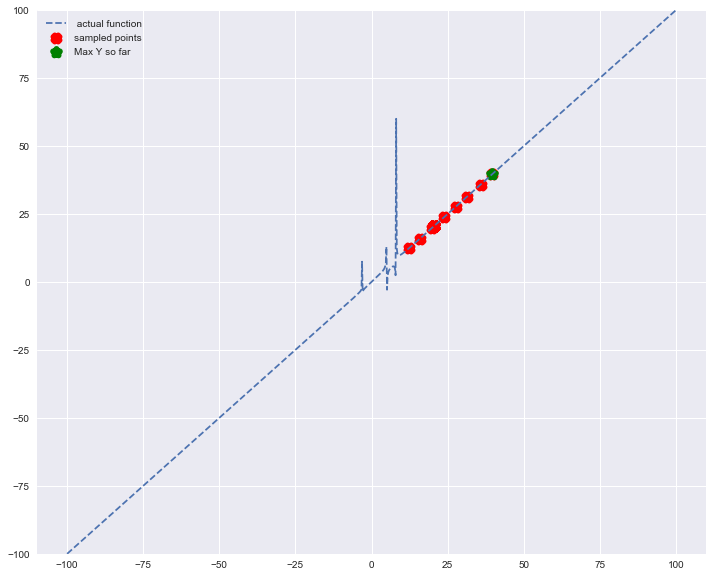

19 domain L
661  domain H
20.6521096283 m v 0.0014616058943 point [ 20.64824121]
22.4311289781 m v 0.0780459443707 point [ 24.06532663]
26.2110687215 m v 0.0550491200368 point [ 27.48241206]
29.6171685005 m v 0.102188761718 point [ 30.89949749]
20.9107660643 m v 0.704229877895 point [ 34.31658291]
28.5478880219 m v 0.689932492523 point [ 37.73366834]
21.0067771679 m v 0.691794273032 point [ 41.15075377]
0.086914302439 m v 0.999994708212 point [ 44.5678392]
1.04939532333e-06 m v 1.0 point [ 47.98492462]
3.69210569559e-14 m v 1.0 point [ 51.40201005]
3.78525613095e-24 m v 1.0 point [ 54.81909548]
1.13084364484e-36 m v 1.0 point [ 58.2361809]
9.8445528714e-52 m v 1.0 point [ 61.65326633]
2.49732792629e-69 m v 1.0 point [ 65.07035176]
1.84604080085e-89 m v 1.0 point [ 68.48743719]
3.97642834764e-112 m v 1.0 point [ 71.90452261]
2.49592292914e-137 m v 1.0 point [ 75.32160804]
4.56515286172e-165 m v 1.0 point [ 78.73869347]
2.4331317259e-195 m v 1.0 point [ 82.15577889]
3.77887096725e-228 m 

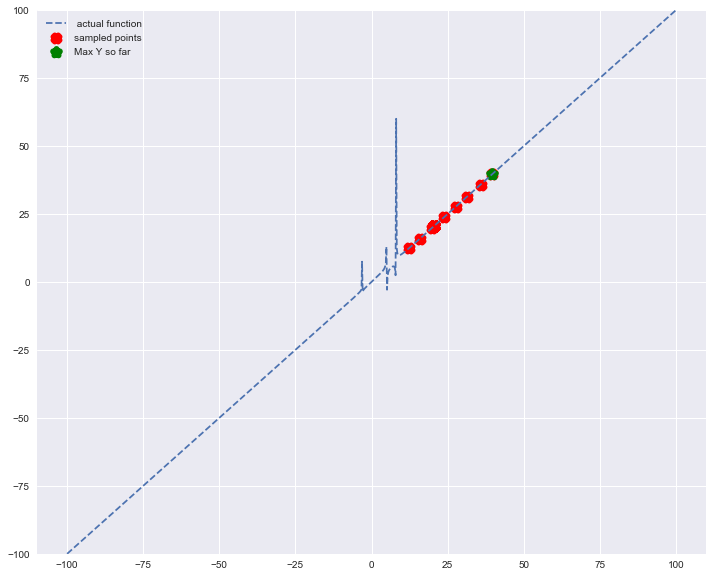

19 domain L
665  domain H
20.6525022396 m v 0.00142013384633 point [ 20.64824121]
22.3896578216 m v 0.0828084504541 point [ 24.08542714]
26.2773318453 m v 0.0510863787017 point [ 27.52261307]
29.7386328485 m v 0.0852818222545 point [ 30.95979899]
21.732176378 m v 0.669028834789 point [ 34.39698492]
28.7279723161 m v 0.687631671312 point [ 37.83417085]
19.1118469401 m v 0.744734530328 point [ 41.27135678]
0.0611830587138 m v 0.999997377698 point [ 44.70854271]
5.33371834529e-07 m v 1.0 point [ 48.14572864]
1.26473215185e-14 m v 1.0 point [ 51.58291457]
8.15710168783e-25 m v 1.0 point [ 55.0201005]
1.43100789052e-37 m v 1.0 point [ 58.45728643]
6.82836952835e-53 m v 1.0 point [ 61.89447236]
8.86259366069e-71 m v 1.0 point [ 65.33165829]
3.12876896566e-91 m v 1.0 point [ 68.76884422]
3.00438086693e-114 m v 1.0 point [ 72.20603015]
7.84703003669e-140 m v 1.0 point [ 75.64321608]
5.57473820726e-168 m v 1.0 point [ 79.08040201]
1.07724000949e-198 m v 1.0 point [ 82.51758794]
5.66199273372e-2

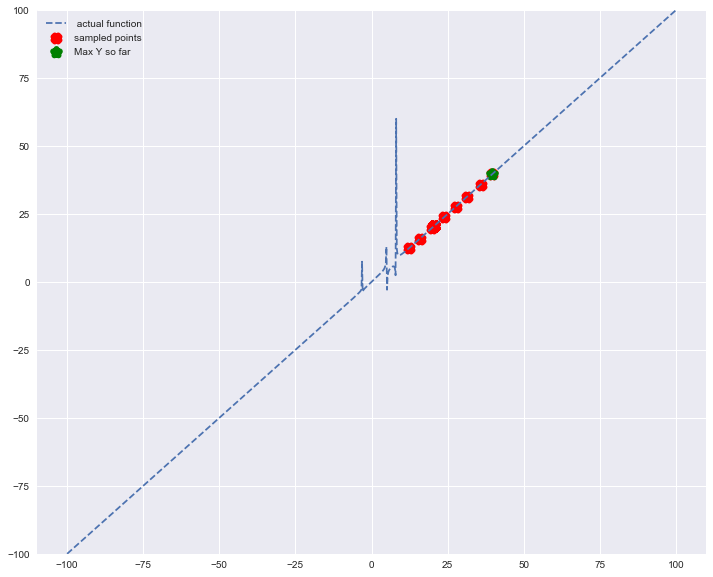

19 domain L
669  domain H
20.6528731856 m v 0.00138095034338 point [ 20.64824121]
22.3460798602 m v 0.0878995346761 point [ 24.10552764]
26.3311759612 m v 0.048623426656 point [ 27.56281407]
29.8251685598 m v 0.0713170680531 point [ 31.0201005]
22.590670549 m v 0.631028485454 point [ 34.47738693]
29.0201290143 m v 0.677023461501 point [ 37.93467337]
17.2628986542 m v 0.791634803738 point [ 41.3919598]
0.0426454013751 m v 0.999998726012 point [ 44.84924623]
2.67612289601e-07 m v 1.0 point [ 48.30653266]
4.26203032786e-15 m v 1.0 point [ 51.7638191]
1.72267391164e-25 m v 1.0 point [ 55.22110553]
1.76711850973e-38 m v 1.0 point [ 58.67839196]
4.60049256599e-54 m v 1.0 point [ 62.13567839]
3.03961828754e-72 m v 1.0 point [ 65.59296482]
5.09694353447e-93 m v 1.0 point [ 69.05025126]
2.16908541501e-116 m v 1.0 point [ 72.50753769]
2.34271546297e-142 m v 1.0 point [ 75.96482412]
6.42152965057e-171 m v 1.0 point [ 79.42211055]
4.46718047534e-202 m v 1.0 point [ 82.87939698]
7.88686782955e-236 

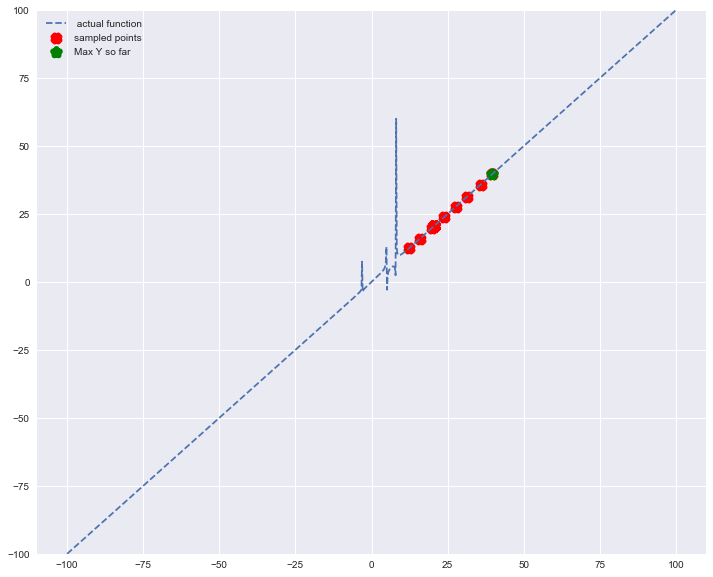

19 domain L
673  domain H
20.6532242113 m v 0.00134387103922 point [ 20.64824121]
22.3004401446 m v 0.0933136388767 point [ 24.12562814]
26.3725837161 m v 0.0476722327597 point [ 27.60301508]
29.8750896004 m v 0.0604665658233 point [ 31.08040201]
23.4773020916 m v 0.590545847517 point [ 34.55778894]
29.4192608383 m v 0.658345626384 point [ 38.03517588]
15.4805814392 m v 0.832374420492 point [ 41.51256281]
0.0294316290366 m v 0.999999393194 point [ 44.98994975]
1.32546129496e-07 m v 1.0 point [ 48.46733668]
1.41295410242e-15 m v 1.0 point [ 51.94472362]
3.56530651566e-26 m v 1.0 point [ 55.42211055]
2.12947969896e-39 m v 1.0 point [ 58.89949749]
3.01063390764e-55 m v 1.0 point [ 62.37688442]
1.00751195063e-73 m v 1.0 point [ 65.85427136]
7.98087074167e-95 m v 1.0 point [ 69.33165829]
1.49643604625e-118 m v 1.0 point [ 72.80904523]
6.64161746498e-145 m v 1.0 point [ 76.28643216]
6.97746020665e-174 m v 1.0 point [ 79.7638191]
1.73511670793e-205 m v 1.0 point [ 83.24120603]
1.0213340908e-2

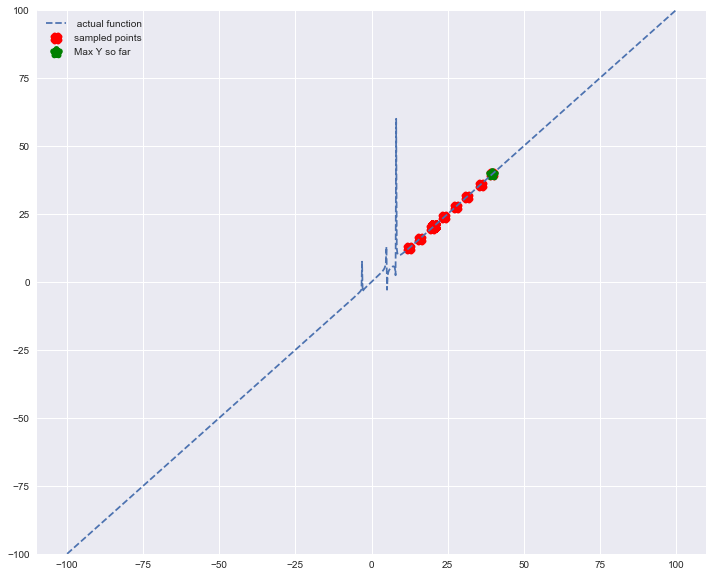

19 domain L
677  domain H
20.6535568794 m v 0.00130873086913 point [ 20.64824121]
22.2527863547 m v 0.0990447275756 point [ 24.14572864]
26.4015956033 m v 0.0482367290074 point [ 27.64321608]
29.8870071561 m v 0.0528664640167 point [ 31.14070352]
24.3827579163 m v 0.547960661985 point [ 34.63819095]
29.9171183644 m v 0.632022003815 point [ 38.13567839]
13.7822156618 m v 0.867096130063 point [ 41.63316583]
0.0201121018167 m v 0.999999716642 point [ 45.13065327]
6.48056794387e-08 m v 1.0 point [ 48.6281407]
4.60821906285e-16 m v 1.0 point [ 52.12562814]
7.23131474266e-27 m v 1.0 point [ 55.62311558]
2.50417982962e-40 m v 1.0 point [ 59.12060302]
1.91371764729e-56 m v 1.0 point [ 62.61809045]
3.22741126403e-75 m v 1.0 point [ 66.11557789]
1.20114339966e-96 m v 1.0 point [ 69.61306533]
9.86505493439e-121 m v 1.0 point [ 73.11055276]
1.78800305671e-147 m v 1.0 point [ 76.6080402]
7.15156525764e-177 m v 1.0 point [ 80.10552764]
6.31245150902e-209 m v 1.0 point [ 83.60301508]
1.22958655056e-2

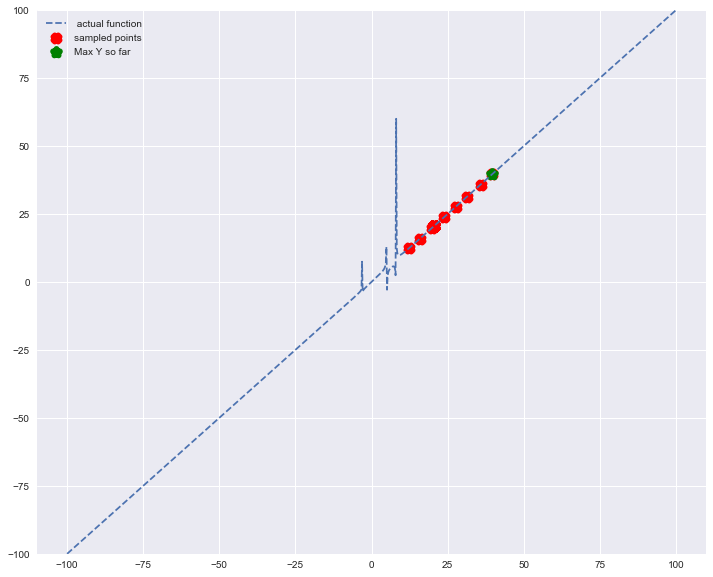

19 domain L
680  domain H
20.6538725934 m v 0.00127538159319 point [ 20.64824121]
22.2157466846 m v 0.103547091144 point [ 24.16080402]
26.4152767241 m v 0.0496525814343 point [ 27.67336683]
29.8703451773 m v 0.0493600981806 point [ 31.18592965]
25.0684544178 m v 0.514906259378 point [ 34.69849246]
30.3486602041 m v 0.607620931032 point [ 38.21105528]
12.5719895988 m v 0.88939119628 point [ 41.72361809]
0.0150182263592 m v 0.999999841999 point [ 45.2361809]
3.75718648832e-08 m v 1.0 point [ 48.74874372]
1.96753877301e-16 m v 1.0 point [ 52.26130653]
2.15675101848e-27 m v 1.0 point [ 55.77386935]
4.94872007354e-41 m v 1.0 point [ 59.28643216]
2.37685084626e-57 m v 1.0 point [ 62.79899497]
2.38961059282e-76 m v 1.0 point [ 66.31155779]
5.02884794702e-98 m v 1.0 point [ 69.8241206]
2.21526679798e-122 m v 1.0 point [ 73.33668342]
2.04267717808e-149 m v 1.0 point [ 76.84924623]
3.94266247497e-179 m v 1.0 point [ 80.36180905]
1.59292609336e-211 m v 1.0 point [ 83.87437186]
1.3471557767e-246 

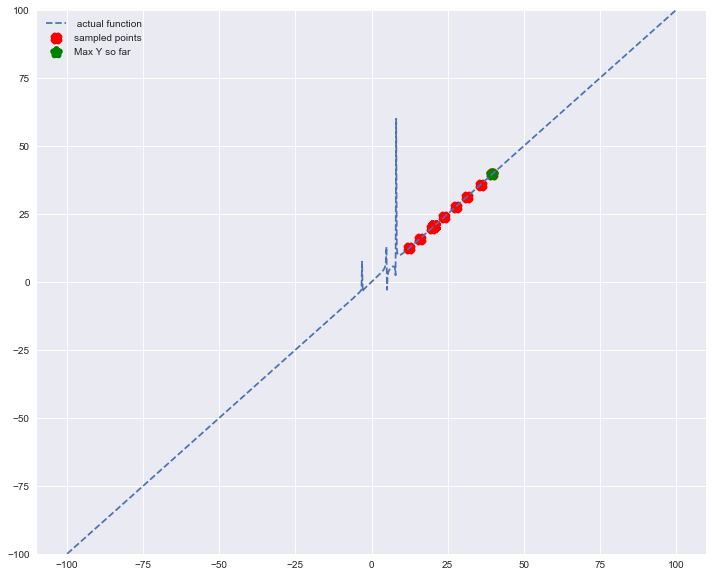

19 domain L
683  domain H
20.654172617 m v 0.0012436897059 point [ 20.64824121]
22.1776246424 m v 0.108221200658 point [ 24.1758794]
26.422102012 m v 0.0519141122856 point [ 27.70351759]
29.8313571429 m v 0.0477653458756 point [ 31.23115578]
25.755269826 m v 0.481127193282 point [ 34.75879397]
30.8237451881 m v 0.57958152059 point [ 38.28643216]
11.4213816578 m v 0.908696341915 point [ 41.81407035]
0.0111522288887 m v 0.999999912875 point [ 45.34170854]
2.16248951246e-08 m v 1.0 point [ 48.86934673]
8.32369389224e-17 m v 1.0 point [ 52.39698492]
6.35986239364e-28 m v 1.0 point [ 55.92462312]
9.64603571201e-42 m v 1.0 point [ 59.45226131]
2.9041533143e-58 m v 1.0 point [ 62.9798995]
1.73564036445e-77 m v 1.0 point [ 66.50753769]
2.05906222583e-99 m v 1.0 point [ 70.03517588]
4.84896142258e-124 m v 1.0 point [ 73.56281407]
2.26671810936e-151 m v 1.0 point [ 77.09045226]
2.10337073669e-181 m v 1.0 point [ 80.61809045]
3.87439297346e-214 m v 1.0 point [ 84.14572864]
1.41664501309e-249 m v 

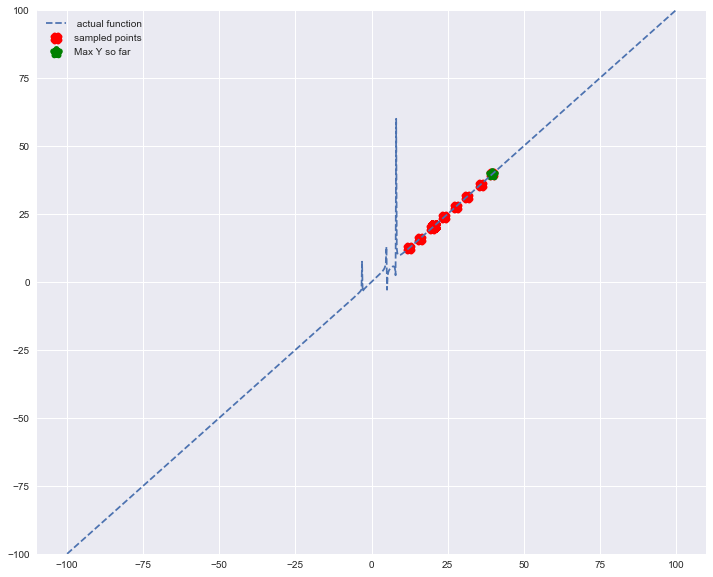

19 domain L
686  domain H
20.6544580916 m v 0.00121353464992 point [ 20.64824121]
22.1384431901 m v 0.113064010592 point [ 24.19095477]
26.4221521956 m v 0.0550140539223 point [ 27.73366834]
29.7698107034 m v 0.0480968064894 point [ 31.27638191]
26.4390998361 m v 0.446852076143 point [ 34.81909548]
31.3358585636 m v 0.54828353017 point [ 38.36180905]
10.3338451358 m v 0.925246225005 point [ 41.90452261]
0.00823543497223 m v 0.999999952489 point [ 45.44723618]
1.23562544323e-08 m v 1.0 point [ 48.98994975]
3.48908475371e-17 m v 1.0 point [ 52.53266332]
1.85421626511e-28 m v 1.0 point [ 56.07537688]
1.85452821074e-42 m v 1.0 point [ 59.61809045]
3.49084601732e-59 m v 1.0 point [ 63.16080402]
1.2366651748e-78 m v 1.0 point [ 66.70351759]
8.24513479518e-101 m v 1.0 point [ 70.24623116]
1.03458834026e-125 m v 1.0 point [ 73.78894472]
2.4432144576e-153 m v 1.0 point [ 77.33165829]
1.08587488891e-183 m v 1.0 point [ 80.87437186]
9.08285081488e-217 m v 1.0 point [ 84.41708543]
1.42984434585e-2

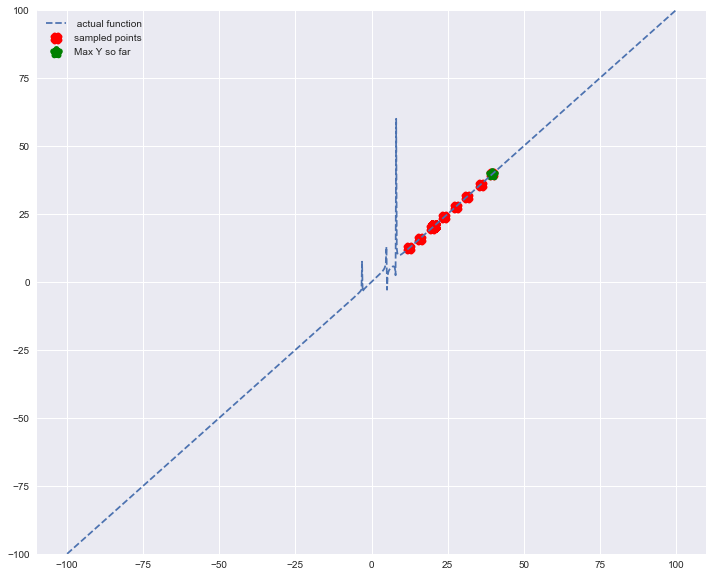

19 domain L
689  domain H
20.6547300505 m v 0.00118480728345 point [ 20.64824121]
22.0982260654 m v 0.118072340837 point [ 24.20603015]
26.4155258694 m v 0.0589426261776 point [ 27.7638191]
29.6855788136 m v 0.0503565035085 point [ 31.32160804]
27.1158572732 m v 0.412326702991 point [ 34.87939698]
31.8777998284 m v 0.514160308585 point [ 38.43718593]
9.31178834332 m v 0.939294981646 point [ 41.99497487]
0.00604774189613 m v 0.999999974378 point [ 45.55276382]
7.0090837518e-09 m v 1.0 point [ 49.11055276]
1.44913736752e-17 m v 1.0 point [ 52.66834171]
5.34488067197e-29 m v 1.0 point [ 56.22613065]
3.51679152746e-43 m v 1.0 point [ 59.7839196]
4.12795911761e-60 m v 1.0 point [ 63.34170854]
8.64379190318e-80 m v 1.0 point [ 66.89949749]
3.22889089588e-102 m v 1.0 point [ 70.45728643]
2.15170431318e-127 m v 1.0 point [ 74.01507538]
2.55794947921e-155 m v 1.0 point [ 77.57286432]
5.42477196889e-186 m v 1.0 point [ 81.13065327]
2.05234876406e-219 m v 1.0 point [ 84.68844221]
1.38516335418e-2

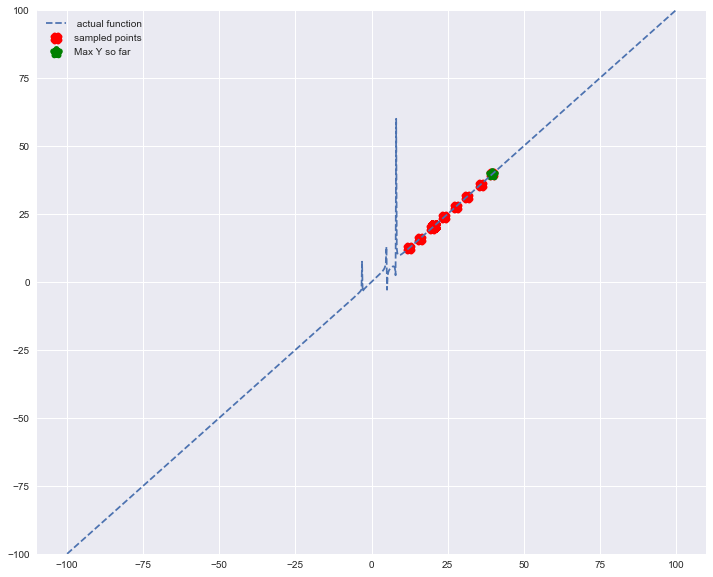

19 domain L
692  domain H
20.6549894312 m v 0.00115740856033 point [ 20.64824121]
22.0569977692 m v 0.123242880549 point [ 24.22110553]
26.4023392634 m v 0.0636875716885 point [ 27.79396985]
29.5786405995 m v 0.0545339557208 point [ 31.36683417]
27.7815028217 m v 0.377812096277 point [ 34.93969849]
32.4417826599 m v 0.477695488308 point [ 38.51256281]
8.35663406155 m v 0.951105206706 point [ 42.08542714]
0.00441653616068 m v 0.999999986336 point [ 45.65829146]
3.94709183325e-09 m v 1.0 point [ 49.23115578]
5.96362338742e-18 m v 1.0 point [ 52.8040201]
1.52328302043e-29 m v 1.0 point [ 56.37688442]
6.57791726042e-44 m v 1.0 point [ 59.94974874]
4.80212681901e-61 m v 1.0 point [ 63.52261307]
5.92674520701e-81 m v 1.0 point [ 67.09547739]
1.23662010379e-103 m v 1.0 point [ 70.66834171]
4.36208135716e-129 m v 1.0 point [ 74.24120603]
2.6012891739e-157 m v 1.0 point [ 77.81407035]
2.62253274198e-188 m v 1.0 point [ 81.38693467]
4.46982600533e-222 m v 1.0 point [ 84.95979899]
1.28794622395e-

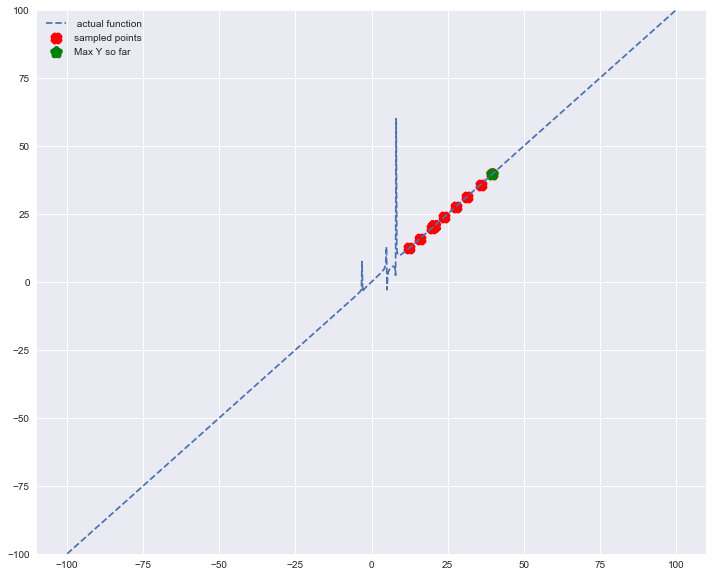

19 domain L
695  domain H
20.6552370867 m v 0.00113124838911 point [ 20.64824121]
22.014783553 m v 0.128572192097 point [ 24.2361809]
26.3827259641 m v 0.0692342009414 point [ 27.8241206]
29.4490816805 m v 0.0606063662209 point [ 31.4120603]
28.4320760262 m v 0.343582070572 point [ 35.]
33.0195433886 m v 0.439418517609 point [ 38.5879397]
7.46889277853 m v 0.960938652456 point [ 42.1758794]
0.00320739293654 m v 0.999999992793 point [ 45.7638191]
2.20665676867e-09 m v 1.0 point [ 49.35175879]
2.43171951891e-18 m v 1.0 point [ 52.93969849]
4.29228102708e-30 m v 1.0 point [ 56.52763819]
1.21355311714e-44 m v 1.0 point [ 60.11557789]
5.49573021691e-62 m v 1.0 point [ 63.70351759]
3.9864653536e-82 m v 1.0 point [ 67.29145729]
4.63176542357e-105 m v 1.0 point [ 70.87939698]
8.61987746865e-131 m v 1.0 point [ 74.46733668]
2.56951763125e-159 m v 1.0 point [ 78.05527638]
1.22686869568e-190 m v 1.0 point [ 81.64321608]
9.38297463326e-225 m v 1.0 point [ 85.23115578]
1.14942059057e-261 m v 1.0 po

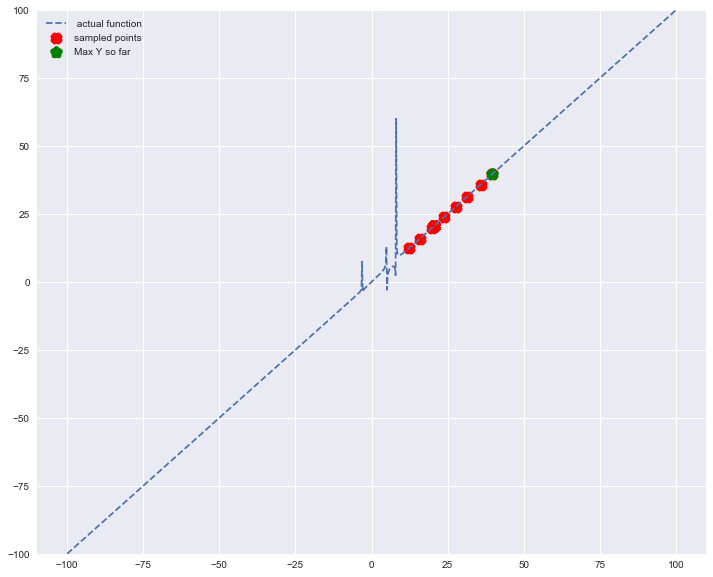

19 domain L
697  domain H
20.6554737944 m v 0.00110624464344 point [ 20.64824121]
21.9860966845 m v 0.132211406521 point [ 24.24623116]
26.3661539121 m v 0.0733690013426 point [ 27.84422111]
29.3502324121 m v 0.0656906877794 point [ 31.44221106]
28.8555109982 m v 0.321059951712 point [ 35.04020101]
33.4081232995 m v 0.413173584811 point [ 38.63819095]
6.91439129403 m v 0.966521741707 point [ 42.2361809]
0.00258338417637 m v 0.999999995325 point [ 45.83417085]
1.49148357964e-09 m v 1.0 point [ 49.4321608]
1.33033666443e-18 m v 1.0 point [ 53.03015075]
1.83323507569e-30 m v 1.0 point [ 56.6281407]
3.90290759481e-45 m v 1.0 point [ 60.22613065]
1.28372468779e-62 m v 1.0 point [ 63.8241206]
6.52332522376e-83 m v 1.0 point [ 67.42211055]
5.12129369133e-106 m v 1.0 point [ 71.0201005]
6.2116052233e-132 m v 1.0 point [ 74.61809045]
1.16396929574e-160 m v 1.0 point [ 78.2160804]
3.3697114636e-192 m v 1.0 point [ 81.81407035]
1.507153269e-226 m v 1.0 point [ 85.4120603]
1.0414433177e-263 m v 1.

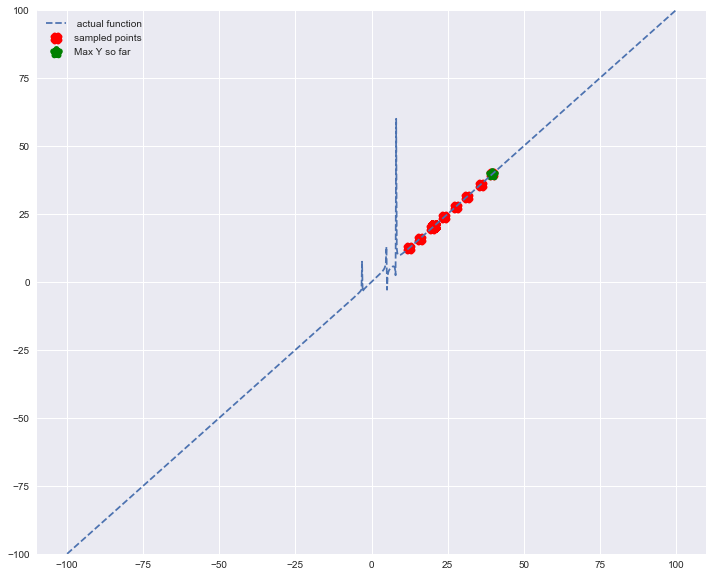

19 domain L
699  domain H
20.6557002646 m v 0.00108232230083 point [ 20.64824121]
21.9569914247 m v 0.135918523115 point [ 24.25628141]
26.3468409212 m v 0.0778469366495 point [ 27.86432161]
29.2414955672 m v 0.0715887848176 point [ 31.47236181]
29.2694254501 m v 0.298876117157 point [ 35.08040201]
33.7963776224 m v 0.386552905426 point [ 38.68844221]
6.3894449337 m v 0.971410983491 point [ 42.29648241]
0.00207563545917 m v 0.999999996982 point [ 45.90452261]
1.0048434858e-09 m v 1.0 point [ 49.51256281]
7.24824769099e-19 m v 1.0 point [ 53.12060302]
7.79031137352e-31 m v 1.0 point [ 56.72864322]
1.24756675485e-45 m v 1.0 point [ 60.33668342]
2.97687059301e-63 m v 1.0 point [ 63.94472362]
1.05838409485e-83 m v 1.0 point [ 67.55276382]
5.60678418493e-107 m v 1.0 point [ 71.16080402]
4.42559390824e-133 m v 1.0 point [ 74.76884422]
5.20494887041e-162 m v 1.0 point [ 78.37688442]
9.12112821886e-194 m v 1.0 point [ 81.98492462]
2.38159461681e-228 m v 1.0 point [ 85.59296482]
9.26561616468e-

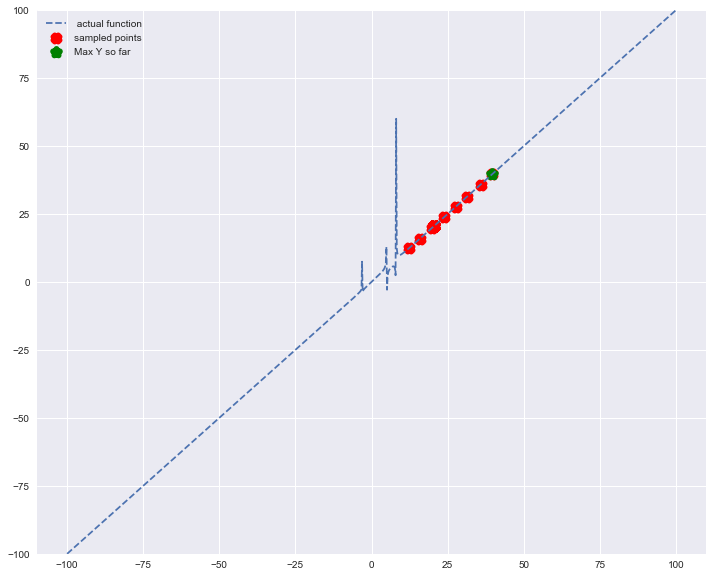

19 domain L
701  domain H
20.6559171474 m v 0.00105941269082 point [ 20.64824121]
21.92747578 m v 0.139692434778 point [ 24.26633166]
26.3248389848 m v 0.0826619277502 point [ 27.88442211]
29.1229747997 m v 0.0782852348338 point [ 31.50251256]
29.6727437361 m v 0.277117246981 point [ 35.12060302]
34.181654409 m v 0.359739150303 point [ 38.73869347]
5.89364056836 m v 0.975674806298 point [ 42.35678392]
0.0016635598379 m v 0.999999998061 point [ 45.97487437]
6.74799297399e-10 m v 1.0 point [ 49.59296482]
3.93303559433e-19 m v 1.0 point [ 53.21105528]
3.29380681487e-31 m v 1.0 point [ 56.82914573]
3.96355932074e-46 m v 1.0 point [ 60.44723618]
6.85313982614e-64 m v 1.0 point [ 64.06532663]
1.70259288873e-84 m v 1.0 point [ 67.68341709]
6.07783672624e-108 m v 1.0 point [ 71.30150754]
3.11748401169e-134 m v 1.0 point [ 74.91959799]
2.29761063254e-163 m v 1.0 point [ 78.53768844]
2.43313172589e-195 m v 1.0 point [ 82.15577889]
3.70230166714e-230 m v 1.0 point [ 85.77386935]
8.09459222208e-26

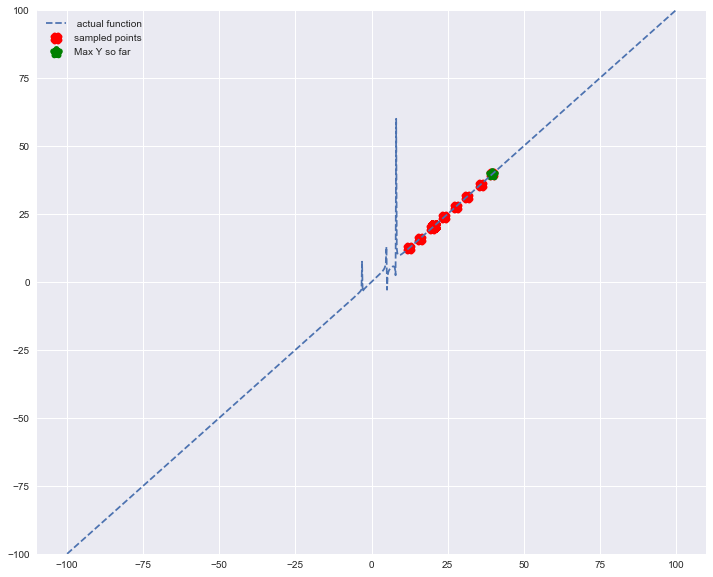

19 domain L
703  domain H
20.6561250389 m v 0.00103745283665 point [ 20.64824121]
21.8975578961 m v 0.143532012069 point [ 24.27638191]
26.3002032769 m v 0.0878074577005 point [ 27.90452261]
28.9947942572 m v 0.0857624651628 point [ 31.53266332]
30.0644259384 m v 0.255870355845 point [ 35.16080402]
34.5612866552 m v 0.332919243585 point [ 38.78894472]
5.42644487581 m v 0.979377840715 point [ 42.41708543]
0.00132999813433 m v 0.999999998761 point [ 46.04522613]
4.51696866043e-10 m v 1.0 point [ 49.67336683]
2.12542660924e-19 m v 1.0 point [ 53.30150754]
1.38563255999e-31 m v 1.0 point [ 56.92964824]
1.25156375314e-46 m v 1.0 point [ 60.55778894]
1.56624899143e-64 m v 1.0 point [ 64.18592965]
2.7156360305e-85 m v 1.0 point [ 67.81407035]
6.52356885173e-109 m v 1.0 point [ 71.44221106]
2.17121019265e-135 m v 1.0 point [ 75.07035176]
1.00120133079e-164 m v 1.0 point [ 78.69849246]
6.39652199709e-197 m v 1.0 point [ 82.32663317]
5.6619927337e-232 m v 1.0 point [ 85.95477387]
6.94380710778e-

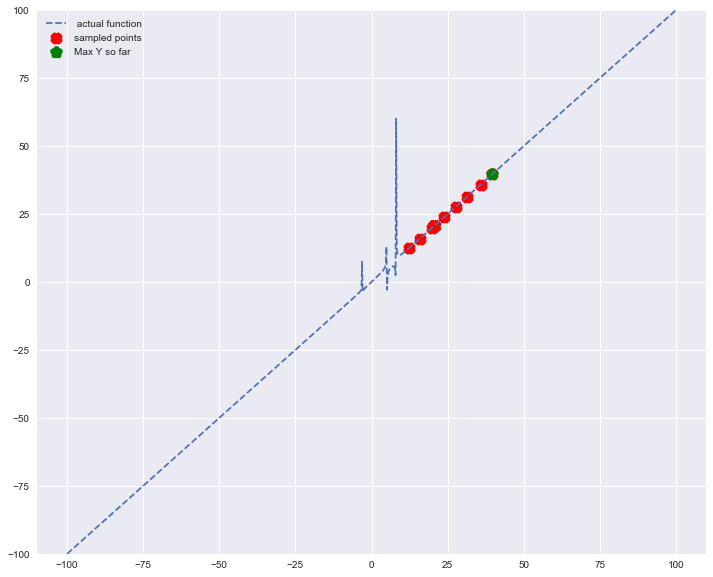

19 domain L
705  domain H
20.656324487 m v 0.00101638487713 point [ 20.64824121]
21.8672460557 m v 0.147436103771 point [ 24.28643216]
26.2729920913 m v 0.0932765825207 point [ 27.92462312]
28.857098334 m v 0.0940008370067 point [ 31.56281407]
30.4434717251 m v 0.235222267438 point [ 35.20100503]
34.9326088028 m v 0.30628305372 point [ 38.83919598]
4.98721727119 m v 0.982580619331 point [ 42.47738693]
0.00106069102861 m v 0.999999999212 point [ 46.11557789]
3.01380943601e-10 m v 1.0 point [ 49.75376884]
1.14389914564e-19 m v 1.0 point [ 53.3919598]
5.79968872375e-32 m v 1.0 point [ 57.03015075]
3.92795620195e-47 m v 1.0 point [ 60.66834171]
3.55364131354e-65 m v 1.0 point [ 64.30653266]
4.29462794657e-86 m v 1.0 point [ 67.94472362]
6.93302080745e-110 m v 1.0 point [ 71.58291457]
1.49508010857e-136 m v 1.0 point [ 75.22110553]
4.3067674821e-166 m v 1.0 point [ 78.85929648]
1.65723229992e-198 m v 1.0 point [ 82.49748744]
8.51844561885e-234 m v 1.0 point [ 86.13567839]
5.84900945388e-272

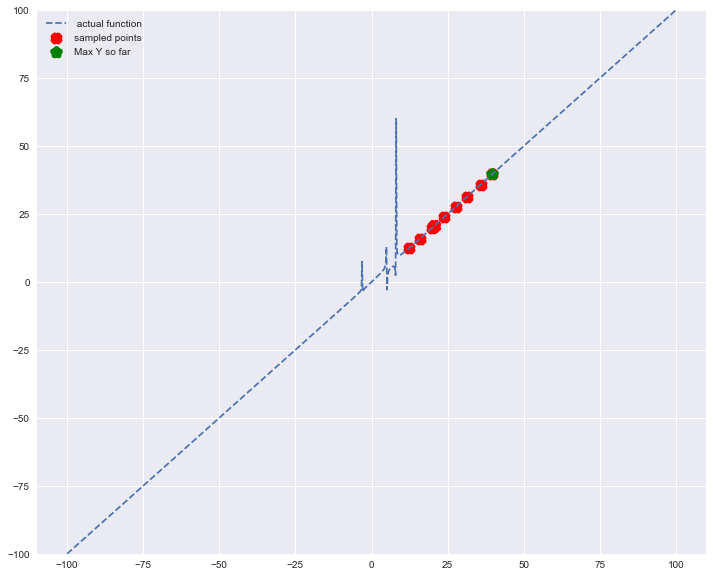

19 domain L
707  domain H
20.6565159957 m v 0.000996155557568 point [ 20.64824121]
21.8365486768 m v 0.15140353746 point [ 24.29648241]
26.2432667758 m v 0.099061942679 point [ 27.94472362]
28.7100513812 m v 0.102978737443 point [ 31.59296482]
30.8089241087 m v 0.215259070299 point [ 35.24120603]
35.2929731854 m v 0.280021984839 point [ 38.88944724]
4.57522277438 m v 0.985339390337 point [ 42.53768844]
0.000843824281535 m v 0.999999999501 point [ 46.18592965]
2.00438320248e-10 m v 1.0 point [ 49.83417085]
6.13130250018e-20 m v 1.0 point [ 53.48241206]
2.41528252464e-32 m v 1.0 point [ 57.13065327]
1.22525459942e-47 m v 1.0 point [ 60.77889447]
8.00438465108e-66 m v 1.0 point [ 64.42713568]
6.73399463801e-87 m v 1.0 point [ 68.07537688]
7.29559620357e-111 m v 1.0 point [ 71.72361809]
1.01786930468e-137 m v 1.0 point [ 75.3718593]
1.82880101292e-167 m v 1.0 point [ 79.0201005]
4.23140014005e-200 m v 1.0 point [ 82.66834171]
1.26079635702e-235 m v 1.0 point [ 86.31658291]
4.83781215298e-2

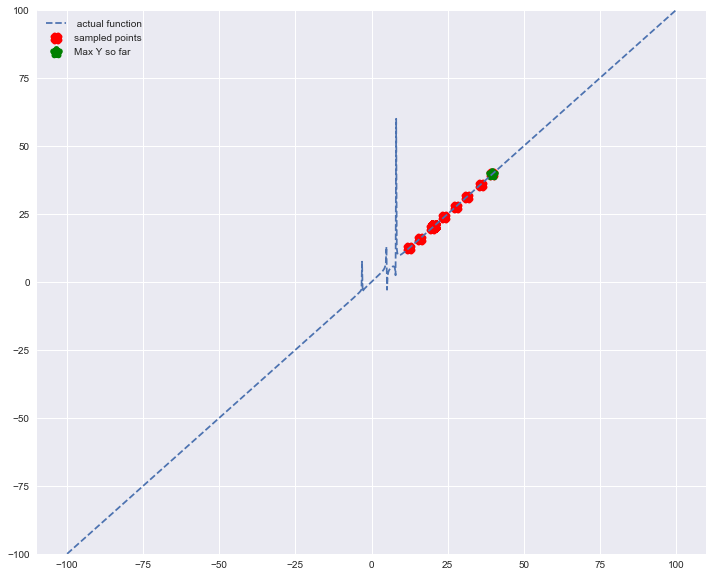

19 domain L
709  domain H
20.65670003 m v 0.000976715780291 point [ 20.64824121]
21.8054743101 m v 0.155433120085 point [ 24.30653266]
26.2110916635 m v 0.105155775232 point [ 27.96482412]
28.5538373741 m v 0.112672678861 point [ 31.62311558]
31.1598730924 m v 0.196065560009 point [ 35.28140704]
35.639766306 m v 0.254327480998 point [ 38.93969849]
4.189644683 m v 0.987706031278 point [ 42.59798995]
0.000669638476731 m v 0.999999999686 point [ 46.25628141]
1.32874601811e-10 m v 1.0 point [ 49.91457286]
3.27296331009e-20 m v 1.0 point [ 53.57286432]
1.00077821273e-32 m v 1.0 point [ 57.23115578]
3.7986745882e-48 m v 1.0 point [ 60.88944724]
1.78987987616e-66 m v 1.0 point [ 64.54773869]
1.04691934136e-87 m v 1.0 point [ 68.20603015]
7.60151410328e-112 m v 1.0 point [ 71.86432161]
6.85148217532e-139 m v 1.0 point [ 75.52261307]
7.66595919312e-169 m v 1.0 point [ 79.18090452]
1.06474600272e-201 m v 1.0 point [ 82.83919598]
1.83579032967e-237 m v 1.0 point [ 86.49748744]
3.92914161099e-276 

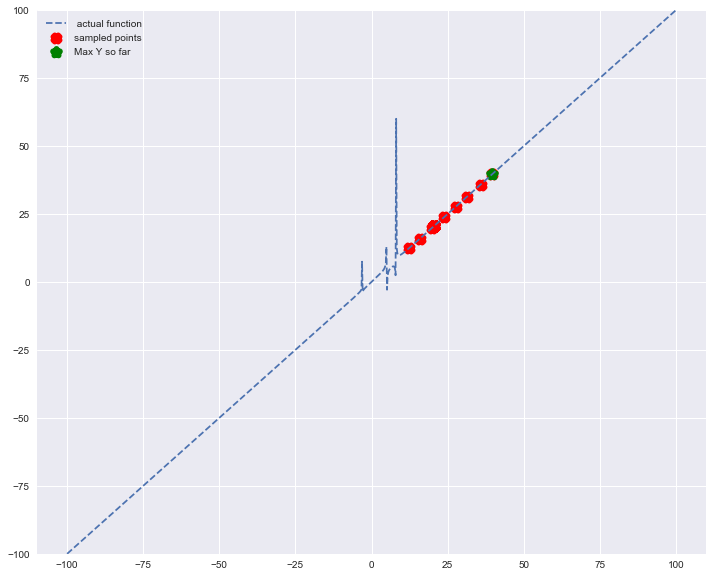

In [474]:


for i in range(samples):
    fig = plt.figure(figsize=(12,10))
    x_sampled_points, y_sampled_points, sampled_var, best_x, best_y = next(gen)
    plt.plot(train_y_x_axis,train_y_numbers_, label=' actual function',linestyle="--")
    print(f"Point on x-axis just sampled ={x_sampled_points[-1]}")
    plt.scatter(x_sampled_points,y_sampled_points, color='red',marker='X',label='sampled points',linewidths=5)
    plt.scatter(best_x,best_y, marker = "*",label='Max Y so far',linewidths=6, color = 'green')
    #plt.gca().fill_between( np.array(x_sampled_points).flat, np.array(x_sampled_points)-2*np.sqrt(sampled_var),
    #                       np.array(x_sampled_points)+2*np.sqrt(sampled_var), color="#dddddd",label='95% confidence')
    
    # Sizes for the axis
    train_y_x_axis = np.array(np.linspace(-100,100,1000))
    train_y_numbers_ = [train_y_func(i) for i  in train_y_x_axis]
    
    

    plt.legend()
    plt.ylim(-100,100)
    plt.show();
    
    # pause so we can see the graph
    #time.sleep(1);


In [201]:
best_y = train_y_func(10)

In [2388]:
best_y

-0.027201055544468493

In [2389]:
np.array([_ for _ in range(-10,10)]) - best_y

array([-9.97279894, -8.97279894, -7.97279894, -6.97279894, -5.97279894,
       -4.97279894, -3.97279894, -2.97279894, -1.97279894, -0.97279894,
        0.02720106,  1.02720106,  2.02720106,  3.02720106,  4.02720106,
        5.02720106,  6.02720106,  7.02720106,  8.02720106,  9.02720106])

In [1707]:
expected_improvement(np.array([_ for _ in range(1500,2000)]), var_y_pred_diag[0], best_y  ,distribution) # new x-value

array([[ 750.34955314,  750.84955329,  751.34955344,  751.84955359,
         752.34955374,  752.84955389,  753.34955404,  753.84955418,
         754.34955433,  754.84955448,  755.34955463,  755.84955478,
         756.34955493,  756.84955508,  757.34955523,  757.84955538,
         758.34955553,  758.84955568,  759.34955583,  759.84955598,
         760.34955613,  760.84955628,  761.34955643,  761.84955658,
         762.34955673,  762.84955688,  763.34955703,  763.84955718,
         764.34955733,  764.84955748,  765.34955763,  765.84955778,
         766.34955794,  766.84955809,  767.34955824,  767.84955839,
         768.34955854,  768.84955869,  769.34955884,  769.849559  ,
         770.34955915,  770.8495593 ,  771.34955945,  771.8495596 ,
         772.34955976,  772.84955991,  773.34956006,  773.84956021,
         774.34956037,  774.84956052,  775.34956067,  775.84956083,
         776.34956098,  776.84956113,  777.34956129,  777.84956144,
         778.34956159,  778.84956175,  779.34956

In [1587]:
# test the y for the current expected improvements
if train_y_func(79.00479131) > best_y:
    best_y = train_y_func(79.00479131)
else:
    pass

In [1589]:
best_y # we found a better pint

1287.601446747913

In [1595]:
mu, sigma_squarred = test_gaussian_process(array([[ 79.00479131]]), train_x, train_y_numbers) # test this new point

In [1596]:
new_dist = stats.norm(mu,np.sqrt(sigma_squarred))

In [1597]:
distribution_new = stats.norm(mu, sigma ) # new distribution

In [1598]:
expected_improvement(mu, sigma, best_y, distribution_new )

array([ 46946.71930156])

In [1599]:
# sample another point

In [1602]:
# test the y for the current expected improvements
if train_y_func(46946.71930156) > best_y:
    best_y = train_y_func(46946.71930156)
else:
    pass

In [1604]:
best_y # we found a better point

1074068611.2654407

In [1605]:
mu, sigma_squarred = test_gaussian_process(array([[ 1074068611.2654407]]), train_x, train_y_numbers) # test this new point

In [1606]:
new_dist = stats.norm(mu,np.sqrt(sigma_squarred))

In [1607]:
distribution_new = stats.norm(mu, sigma ) # new distribution

In [1608]:
expected_improvement(mu, sigma, best_y, distribution_new )

array([ -5.36981876e+08])